# 2.1 Analyses of patterns per trial type

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from matplotlib import colors as mcolors
from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
import collections

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import concatenate_sessions, fix_discontinuities
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, state_identifiability
from plotting_functions import align_bin_design_matrix, states_per_trial_phase, broader_label, traces_over_few_sates

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

## Load data

In [ ]:
bin_size = 0.1
num_train_batches = 5
threshold = 0.05
num_states = 2


# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'


In [ ]:
data_file = "preprocessed_data_v4_171224_alltrials"

if data_file == "preprocessed_data_v4_170724":

    use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
                ['left_X', 'left_Y', 'right_X', 'right_Y'], ['nose_X', 'nose_Y']]
    var_interest_map = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'nose_X']
    idx_init_list = [0, 1, 2, 3, 7]
    idx_end_list = [1, 2, 3, 7, 9]
    
    # Load preprocessed data
    prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/90_trials/' + str(bin_size) + '/'
    os.chdir(prepro_results_path)
    idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + data_file, "rb"))
    collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)
    
    
elif data_file == "preprocessed_data_v4_171224_alltrials":
    use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count']]
    var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count']
    idx_init_list = [0, 1, 2]
    idx_end_list = [1, 2, 3]
    
    # Load preprocessed data
    prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'
    os.chdir(prepro_results_path)
    idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + data_file, "rb"))
    collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)

In [ ]:
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial/4_analyses/'
data_path = '/home/ines/repositories/representation_learning_variability//Models/Sub-trial/4_analyses/'
os.chdir(data_path)
states_trial_type = pd.read_pickle("./states_trial_type01-04-2025")

# Analyses  this need working

In [6]:
def groupby(vars, use_data):
    # Step 1: Group and count occurrences
    count = pd.DataFrame(use_data.groupby(vars)['identifiable_states'].count())  #  'correct',

    # Step 2: Reset index to bring the grouping columns back into the DataFrame
    count = count.reset_index(level=list(np.arange(0, len(vars)-1, 1)))

    # Rename the count column
    count.rename(columns={'identifiable_states': 'count'}, inplace=True)

    # Step 3: Calculate the total counts for each group of 'mouse_name', 'session', 'label'
    count['total'] = count.groupby(vars[:-1])['count'].transform('sum')  # 'broader_label'

    # Step 4: Compute the relative frequency
    count['relative_frequency'] = count['count'] / count['total']

    # Drop the 'total' column if it's no longer needed
    count = count.drop(columns=['total'])

    return count


def plot_states_binned(count):
    trial_epoch = np.unique(count['broader_label'])
    epoch ='Quiescence'
    # contrasts = count.contrast.unique()
    use = count.dropna()
    for epoch in trial_epoch:

        data = use.loc[(use['broader_label']==epoch) & (use['correct']==1.)]
        # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
        plt.figure(figsize=[20, 4])
        sns.barplot(hue='identifiable_states', y='relative_frequency', x='time_bin', data=data, palette='viridis',
                    hue_order= ['000', '001', '010', '100', '110', '101', '011', '111'])
        plt.xlabel('States')
        plt.ylabel('Frequency in trial type/epoch')
        plt.title('Correct - ' + epoch)
        plt.show()

        data = use.loc[(use['broader_label']==epoch) & (use['correct']==0.)]
        # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
        plt.figure(figsize=[20, 4])
        sns.barplot(hue='identifiable_states', y='relative_frequency', x='time_bin', data=data, palette='viridis',
                    hue_order= ['000', '001', '010', '100', '110', '101', '011', '111'])
        plt.xlabel('States')
        plt.ylabel('Frequency in trial type/epoch')
        plt.title('Incorrect - '+epoch)
        plt.show()

## Prepare data for plotting

In [ ]:
exclude_sessions = ['f1db6257-85ef-4385-b415-2d078ec75df2',
'259927fd-7563-4b03-bc5d-17b4d0fa7a55',
'e49d8ee7-24b9-416a-9d04-9be33b655f40',
'6f6d2c8e-28be-49f4-ae4d-06be2d3148c1',
'193fe7a8-4eb5-4f3e-815a-0c45864ddd77',
'f8d5c8b0-b931-4151-b86c-c471e2e80e5d',
'ebc9392c-1ecb-4b4b-a545-4e3d70d23611',
'537677fe-1e24-4755-948c-fa4a4e8ecce5',
'a4747ac8-6a75-444f-b99b-696fff0243fd',
'7be8fec4-406b-4e74-8548-d2885dcc3d5e',
'a71175be-d1fd-47a3-aa93-b830ea3634a1',
'53738f95-bd08-4d9d-9133-483fdb19e8da',
'd901aff5-2250-467a-b4a1-0cb9729df9e2',
'7939711b-8b4d-4251-b698-b97c1eaa846e',
'510b1a50-825d-44ce-86f6-9678f5396e02',
'aad23144-0e52-4eac-80c5-c4ee2decb198',
'd839491f-55d8-4cbe-a298-7839208ba12b',
'72cb5550-43b4-4ef0-add5-e4adfdfb5e02']

exclude_sessions = []  # TODO: check manually which sessions to remove

In [8]:
for m, mat in enumerate(idxs):
    if len(mat) > 35: 
        # try:
        mouse_name = mat[37:]
        session = mat[0:36]
        
        if session not in exclude_sessions:
            var_names = ['avg_wheel_vel', 'Lick count', 'whisker_me']

            # Get mouse data          
            session_trials = session_all[mouse_name][session]
            design_matrix = matrix_all[mouse_name][session][:,0:3]
            unnorm_mat = matrix_all_unnorm[mouse_name][session][var_names]
            unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']

            # Get states per variable and concatenate
            states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/most_likely_states/'
            os.chdir(states_path)

            c_states = []
            for s, set in enumerate(use_sets):
                
                most_likely_states, _ = pickle.load(open("most_likely_states" + set[0] + '_' + mouse_name + session, "rb"))
                # Save
                if len(c_states) == 0:
                    c_states = most_likely_states
                else:
                    c_states = np.vstack((c_states, most_likely_states))      
            
            combined_states = remove_states_str(c_states.T, threshold)
            
            " Prepare data "
            num_timesteps = np.shape(design_matrix)[0]
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(combined_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            design_matrix_heading['Lick count'] = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Lick count']
            
            # Transform states into identifiable states
            identifiable_states = state_identifiability(combined_states, design_matrix_heading)
            
            # Change states back to integer
            state_labels = np.unique(identifiable_states)
            int_state = np.arange(0, len(state_labels), 1).astype(float)
            if state_labels[-1] == 'nan':
                int_state[-1] = np.nan
            # Define the mapping as a dictionary
            mapping = {unique: key for unique, key in zip(state_labels, int_state)}
            inverted_mapping = {v: k for k, v in mapping.items()}

            # Use np.vectorize to apply the mapping
            replace_func = np.vectorize(mapping.get)
            new_states = replace_func(identifiable_states)
            num_states = len(np.unique(new_states))

            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, new_states, multiplier)
            empirical_data['identifiable_states'] = identifiable_states
            
            """ Trial types """
            # Split in trial types
            states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            states_trial['mouse_name'] = mouse_name
            states_trial['session'] = session
            replace_func = np.vectorize(inverted_mapping.get)
            str_states = replace_func(np.array(states_trial['most_likely_states']))
            states_trial['identifiable_states'] = str_states
            states_trial = broader_label(states_trial)
            
            """ Plot  """
            vars = ['contrast', 'time_bin', 'broader_label', 'correct']
            extended_vars = ['contrast', 'time_bin', 'broader_label', 'correct', 'identifiable_states']
            use_data = states_trial.loc[states_trial['elongation']<=1]
            use_data['time_bin'] = pd.cut(use_data['elongation'], 5)
            count = groupby(extended_vars, use_data)
            plot_states_binned(count)
            
        else:
            print(session)


/tmp/ipykernel_7403/2373399546.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

KeyError: 'index'

<AxesSubplot:xlabel='reaction_bin', ylabel='relative_frequency'>

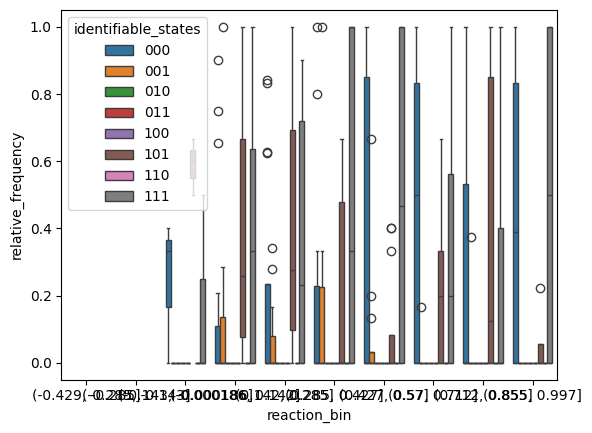

In [76]:
data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae')].dropna()
sns.boxplot(x='time_bin', y='relative_frequency', hue='identifiable_states', data=data)

/tmp/ipykernel_15261/3384389889.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['time_bin'] = pd.cut(use_data['reaction'], 10)


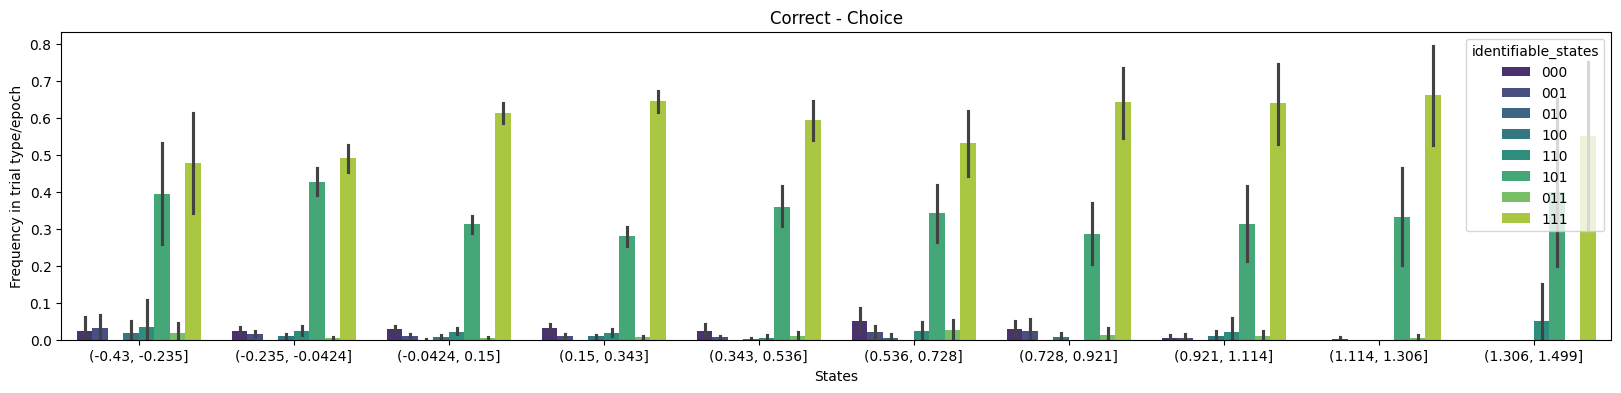

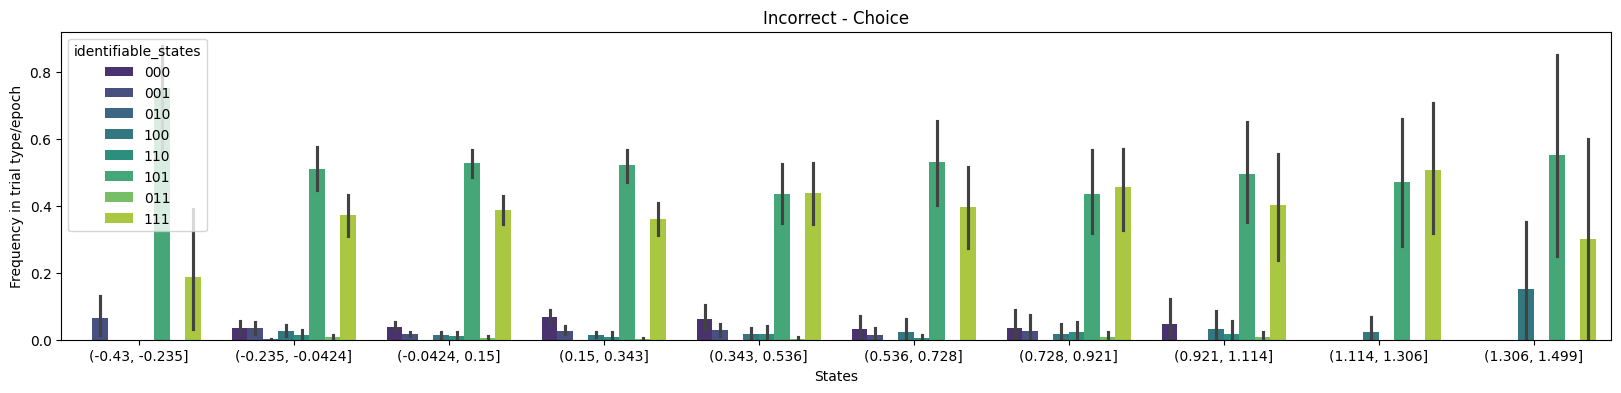

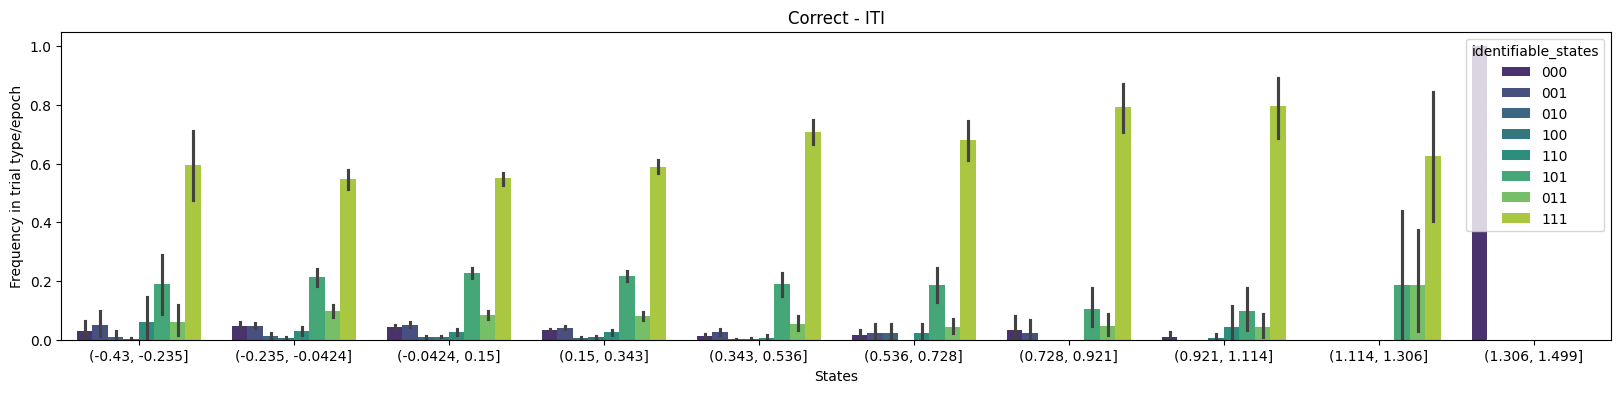

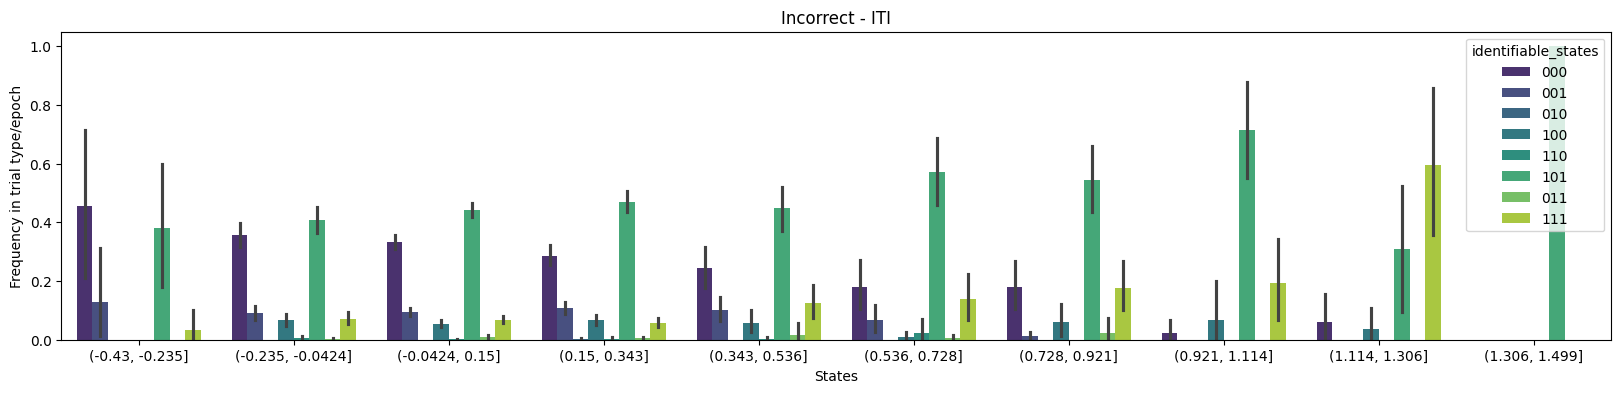

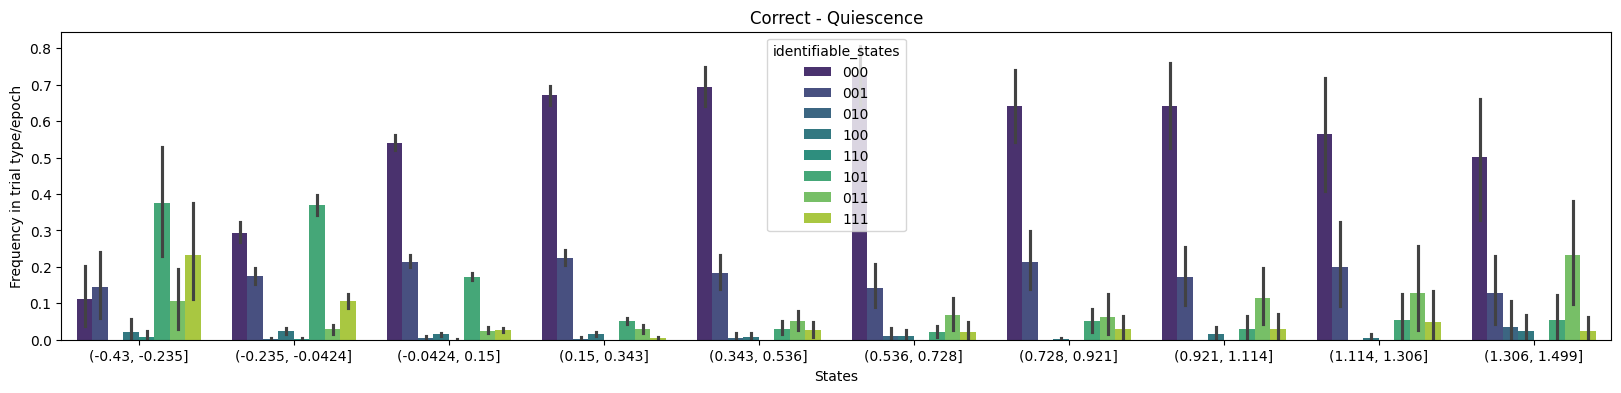

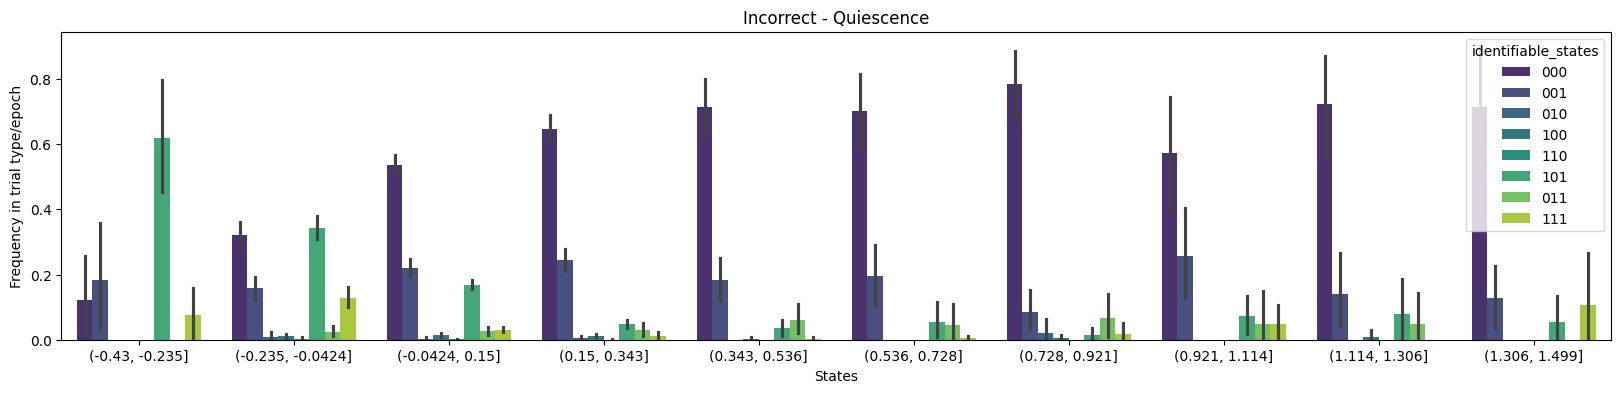

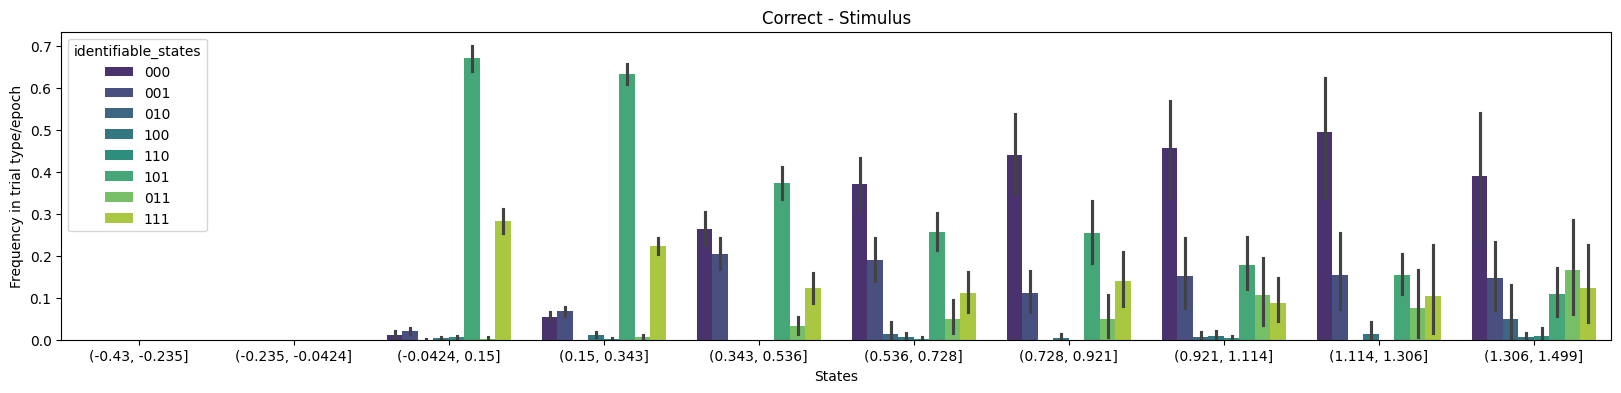

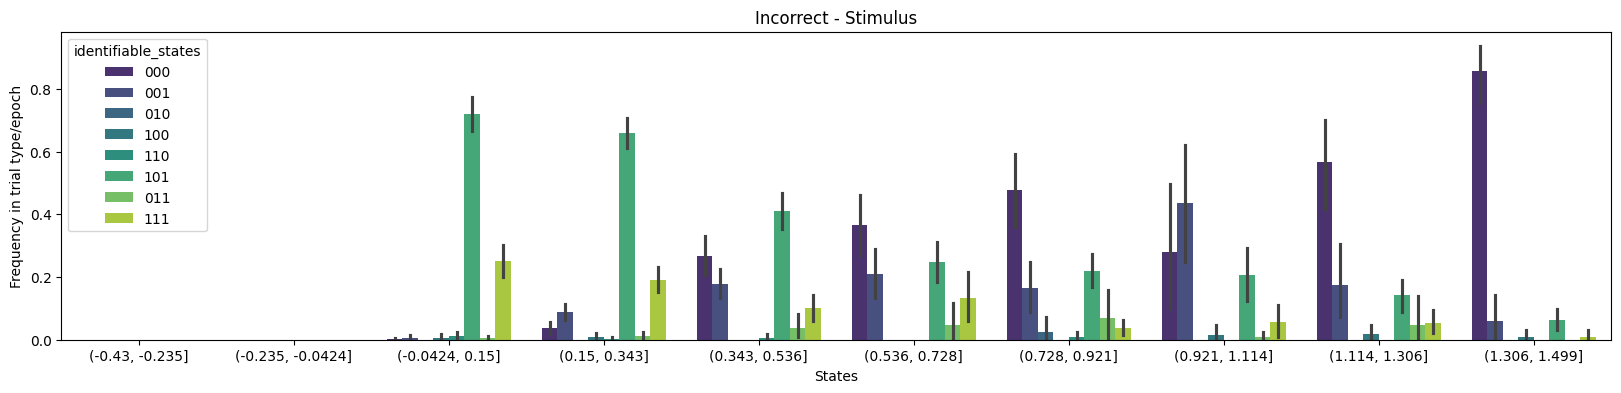

In [145]:
vars = ['mouse_name', 'session', 'contrast', 'time_bin', 'broader_label', 'correct']
extended_vars = ['mouse_name', 'session', 'contrast', 'time_bin', 'broader_label', 'correct', 'identifiable_states']
use_data = states_trial_type.loc[states_trial_type['reaction']<=1.5]
use_data['time_bin'] = pd.cut(use_data['reaction'], 10)
count = groupby(extended_vars, use_data)

trial_epoch = np.unique(count['broader_label'])
use = count.dropna()
for epoch in trial_epoch:

    data = use.loc[(use['broader_label']==epoch) & (use['correct']==1.)]
    # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
    plt.figure(figsize=[20, 4])
    sns.barplot(hue='identifiable_states', y='relative_frequency', x='time_bin', data=data, palette='viridis',
                hue_order= ['000', '001', '010', '100', '110', '101', '011', '111'])
    plt.xlabel('States')
    plt.ylabel('Frequency in trial type/epoch')
    plt.title('Correct - '+epoch)
    plt.show()

    data = use.loc[(use['broader_label']==epoch) & (use['correct']==0.)]
    # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
    plt.figure(figsize=[20, 4])
    sns.barplot(hue='identifiable_states', y='relative_frequency', x='time_bin', data=data, palette='viridis',
                hue_order= ['000', '001', '010', '100', '110', '101', '011', '111'])
    plt.xlabel('States')
    plt.ylabel('Frequency in trial type/epoch')
    plt.title('Incorrect - '+epoch)
    plt.show()


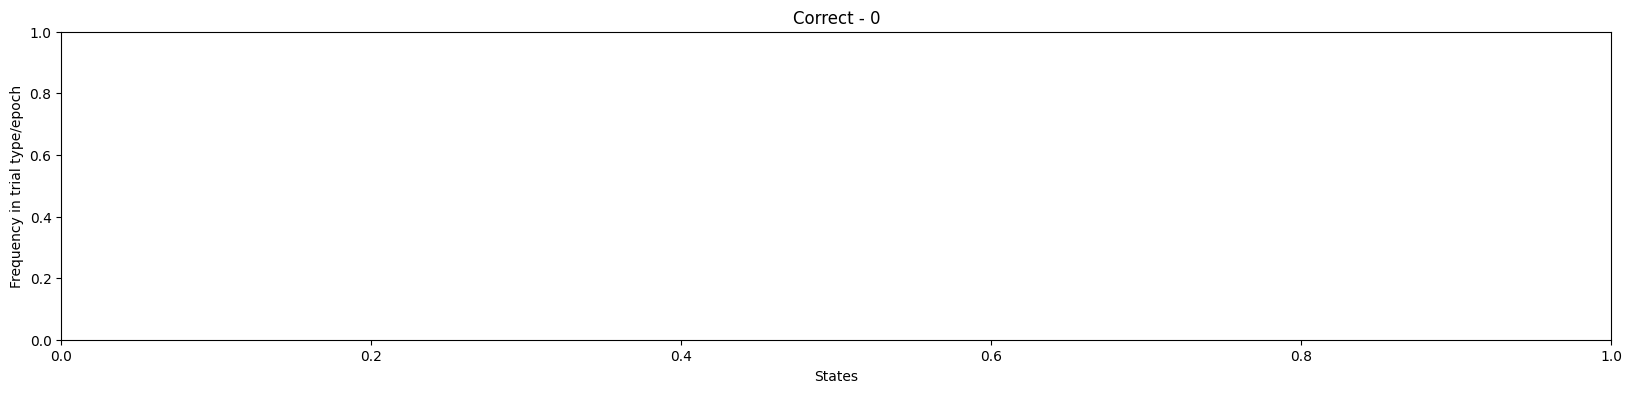

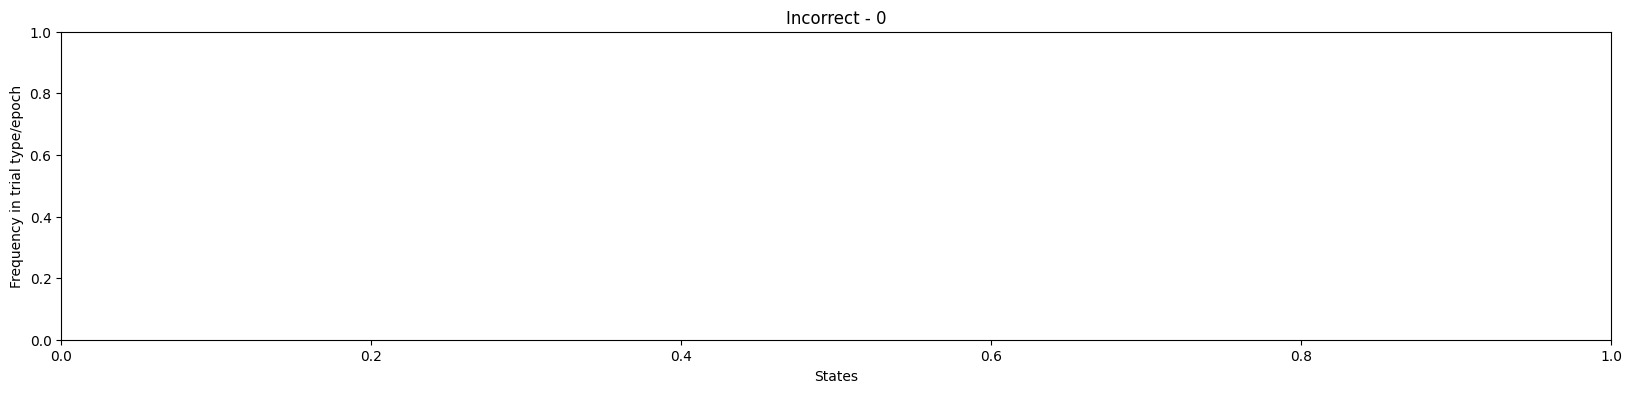

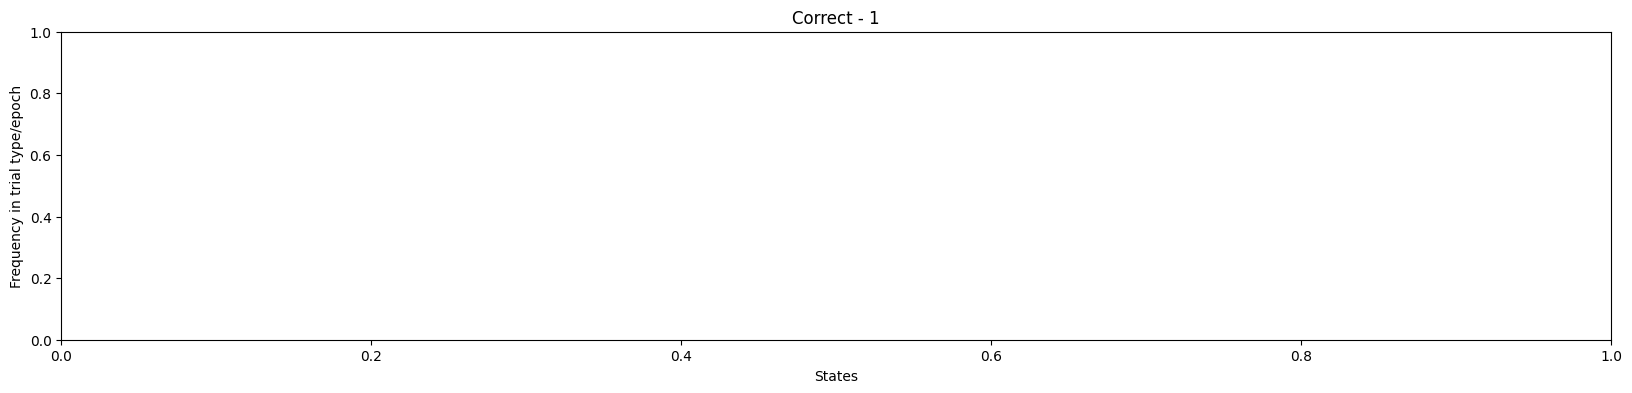

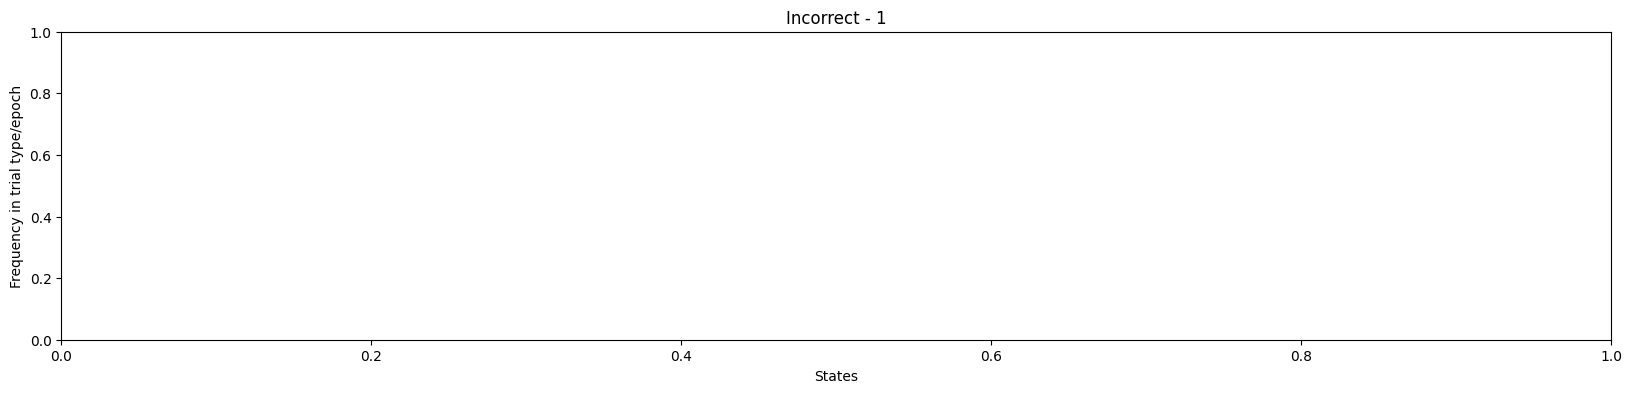

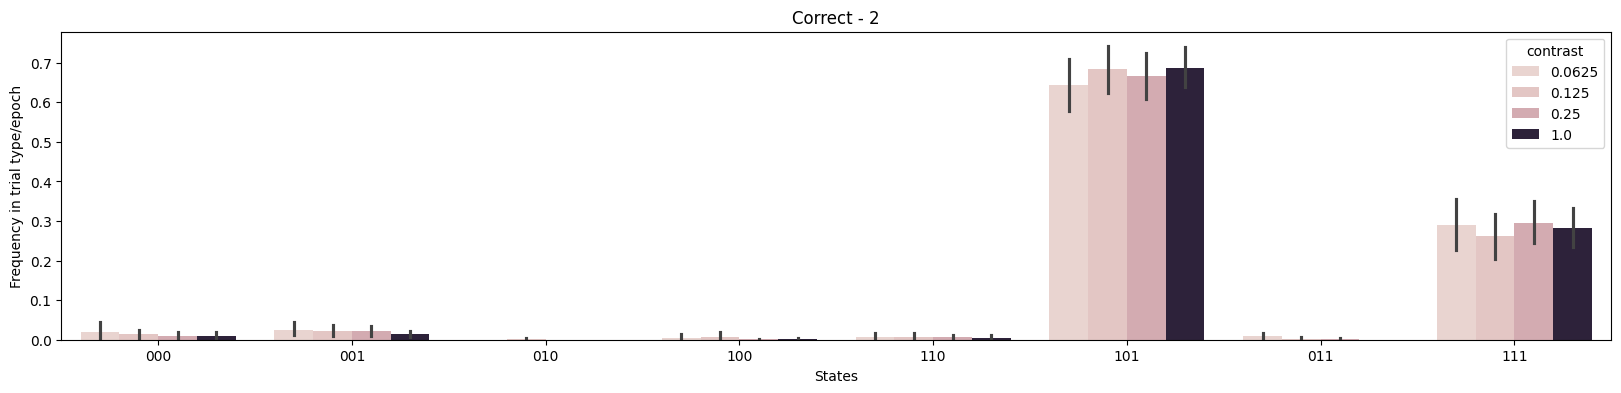

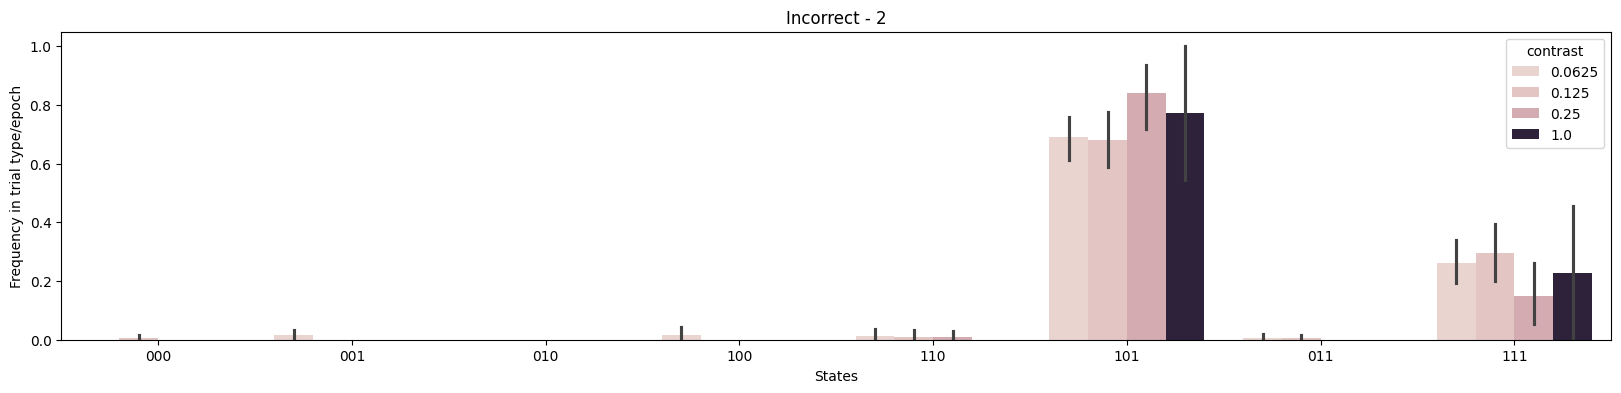

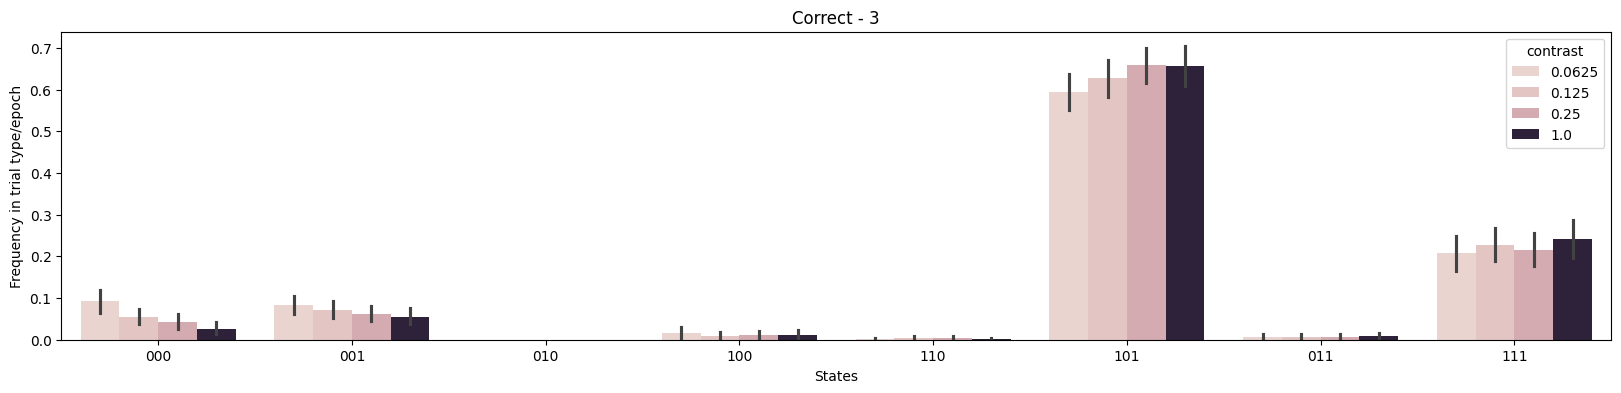

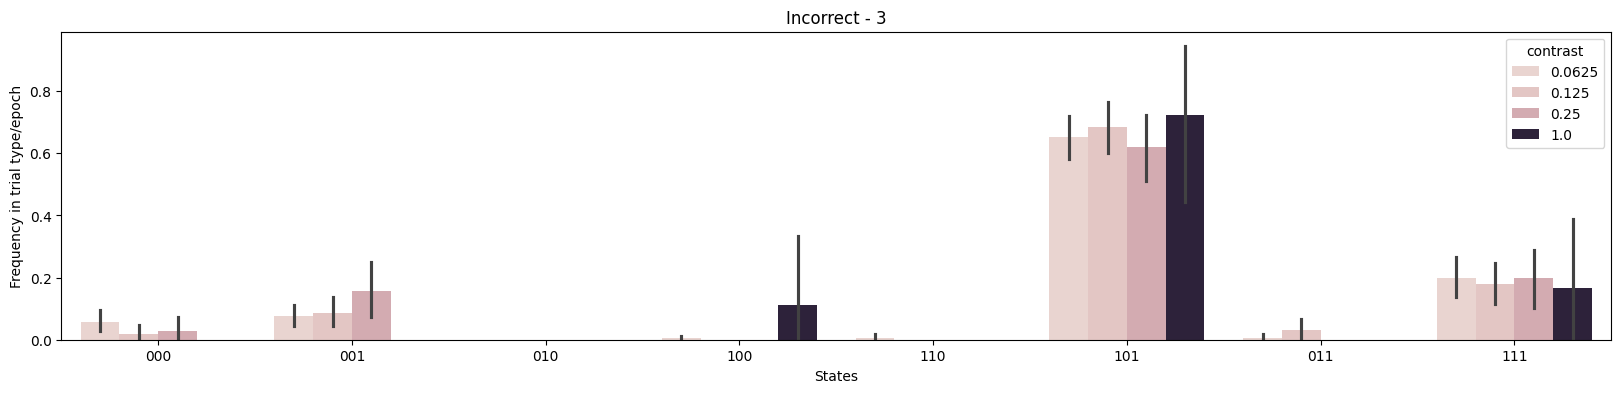

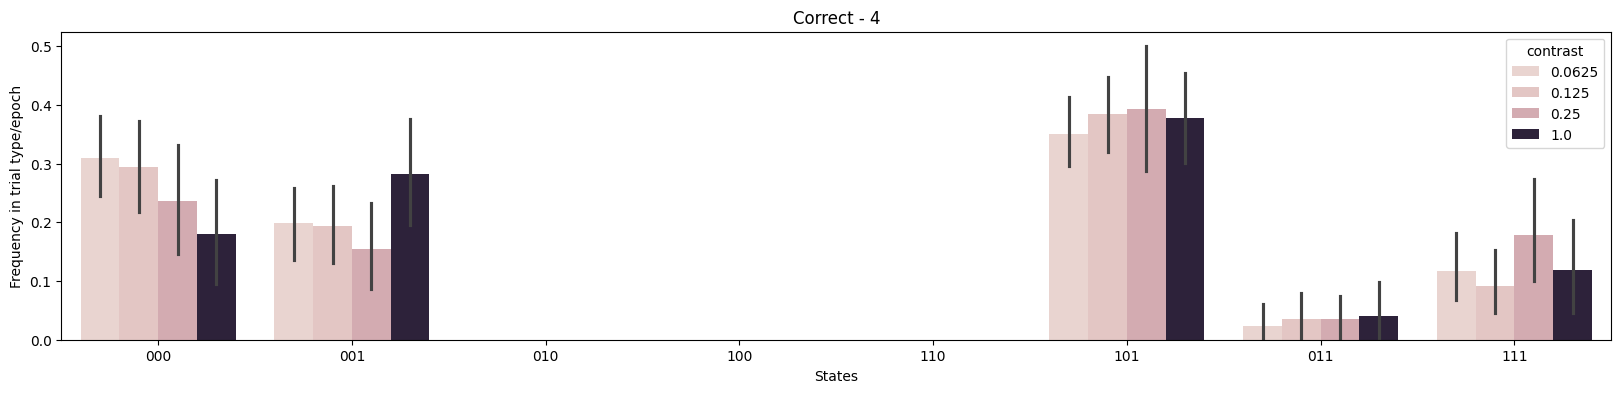

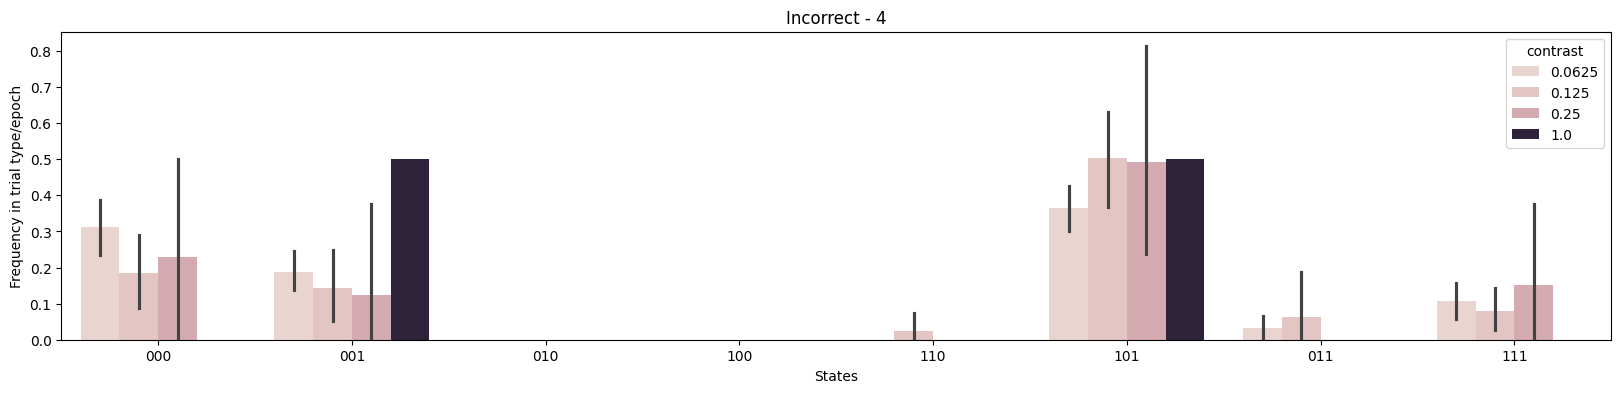

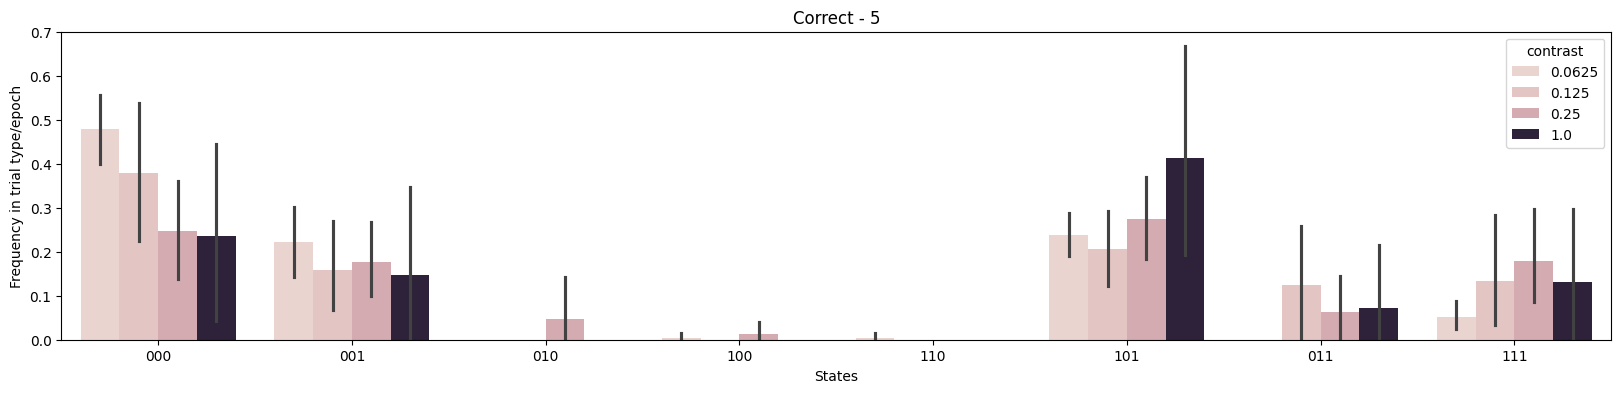

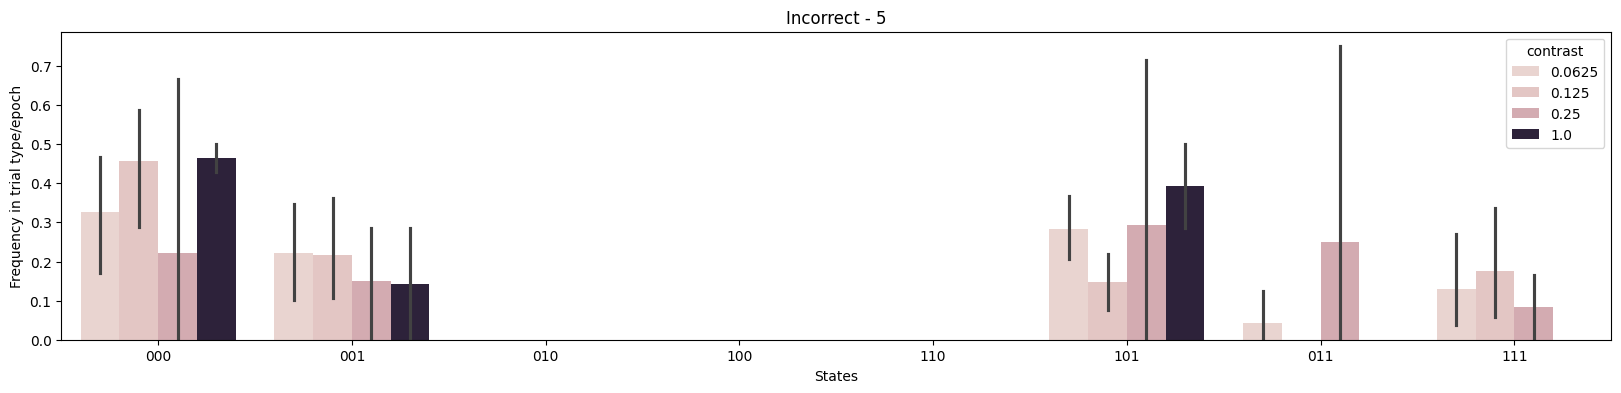

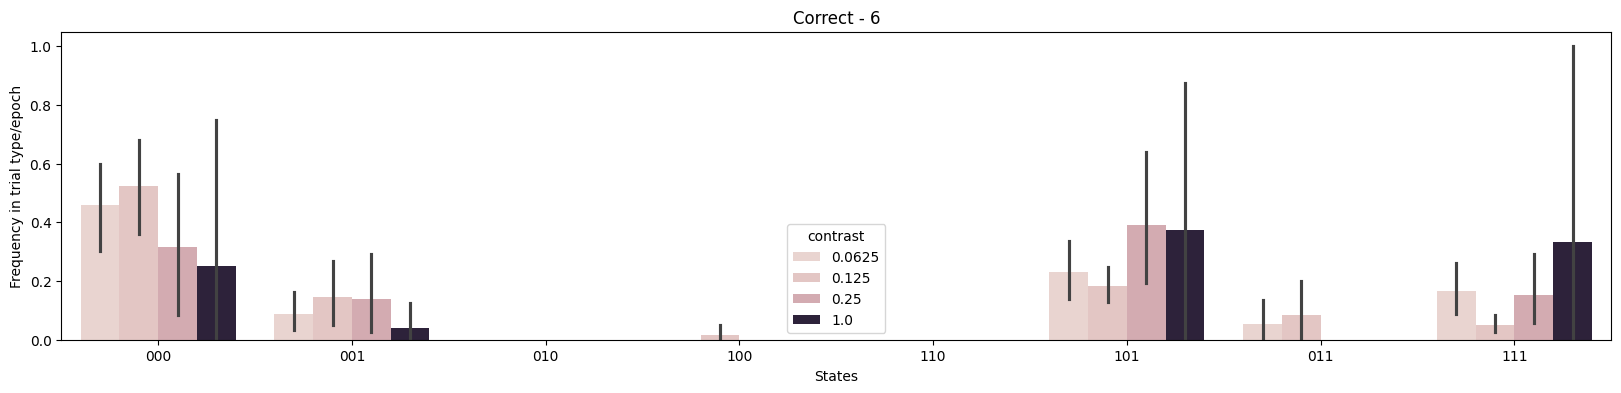

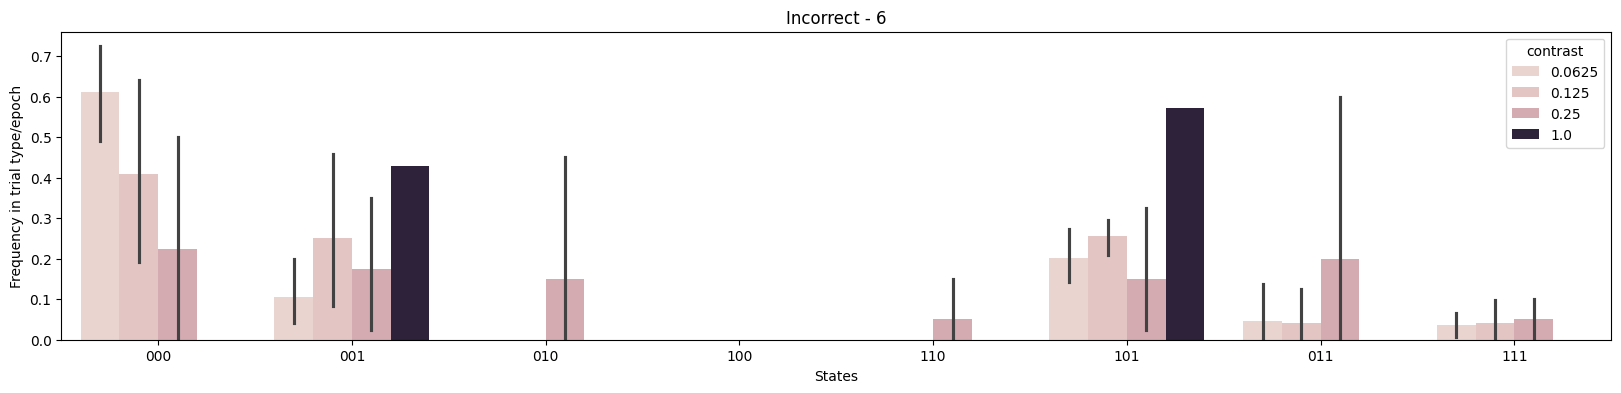

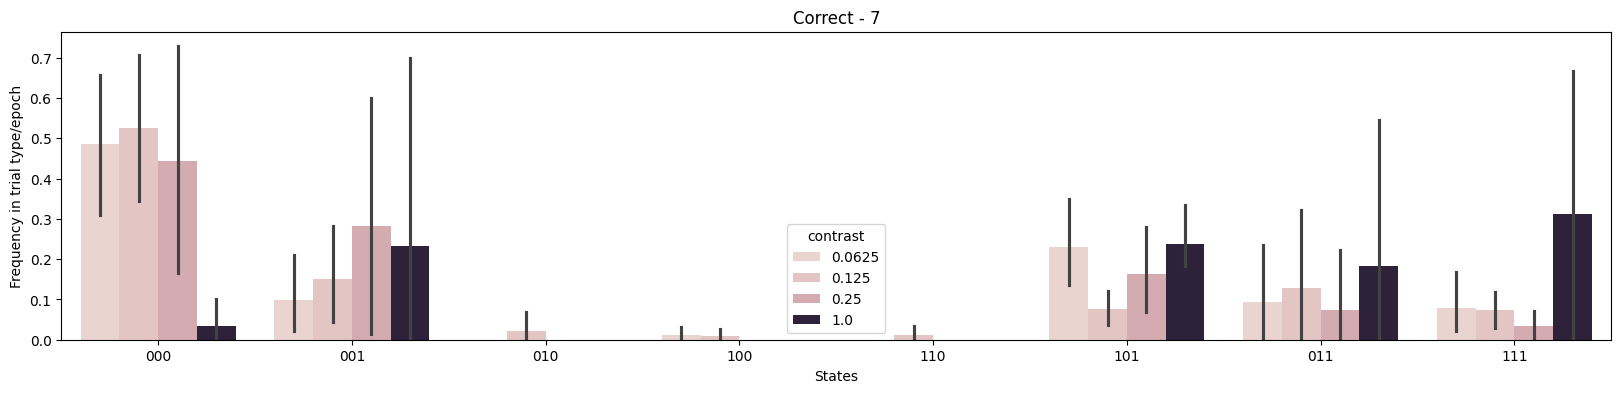

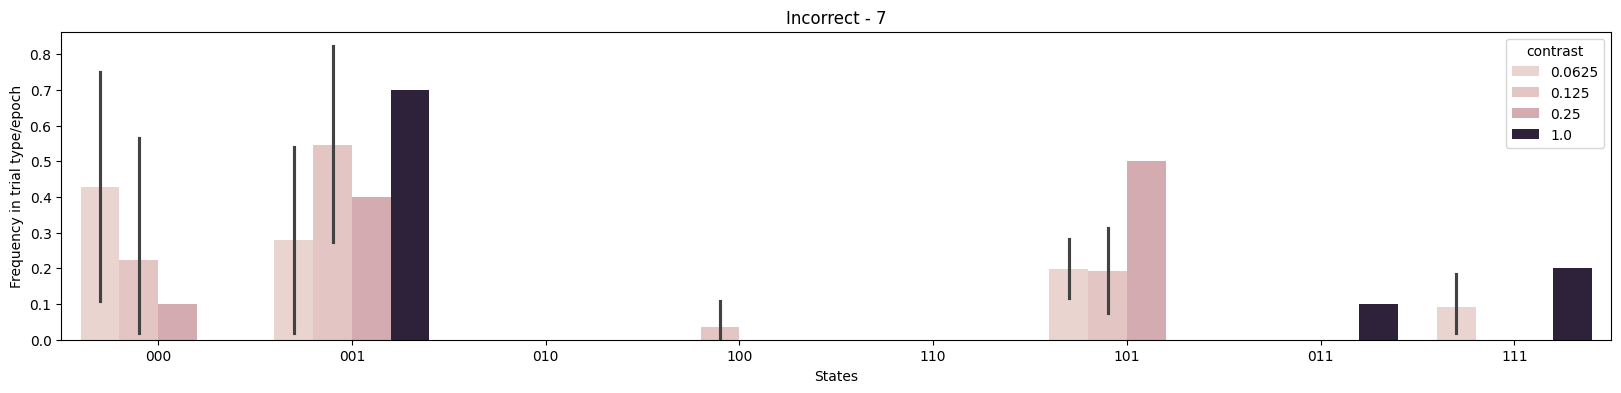

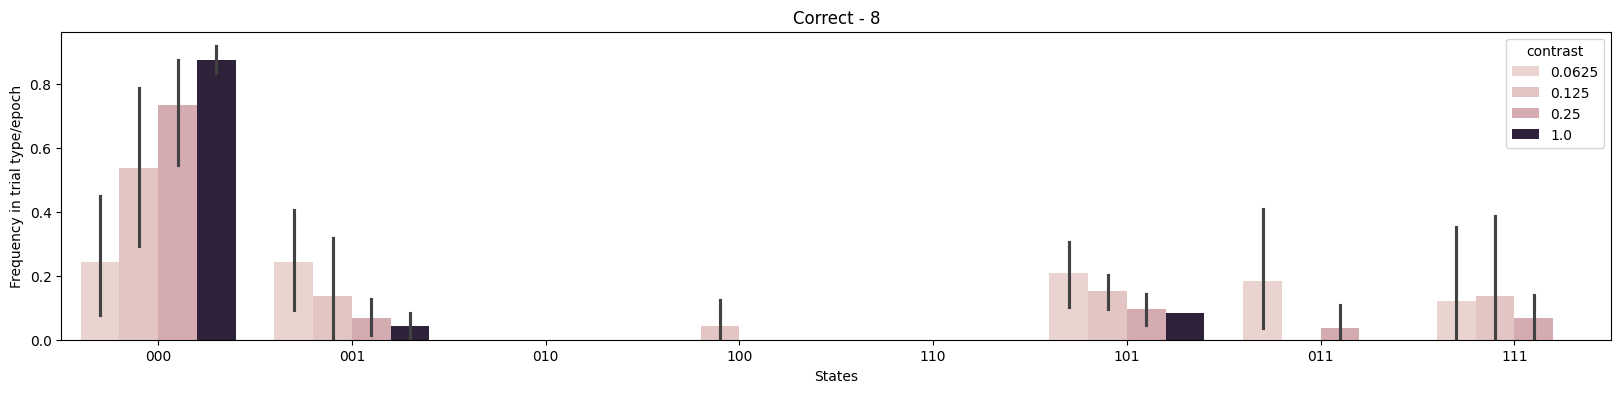

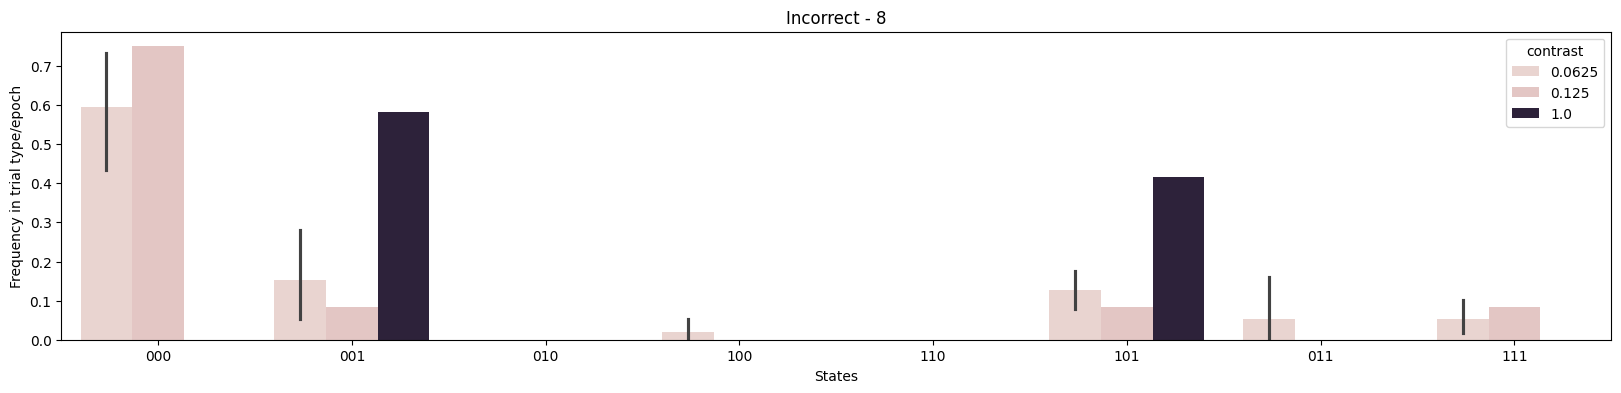

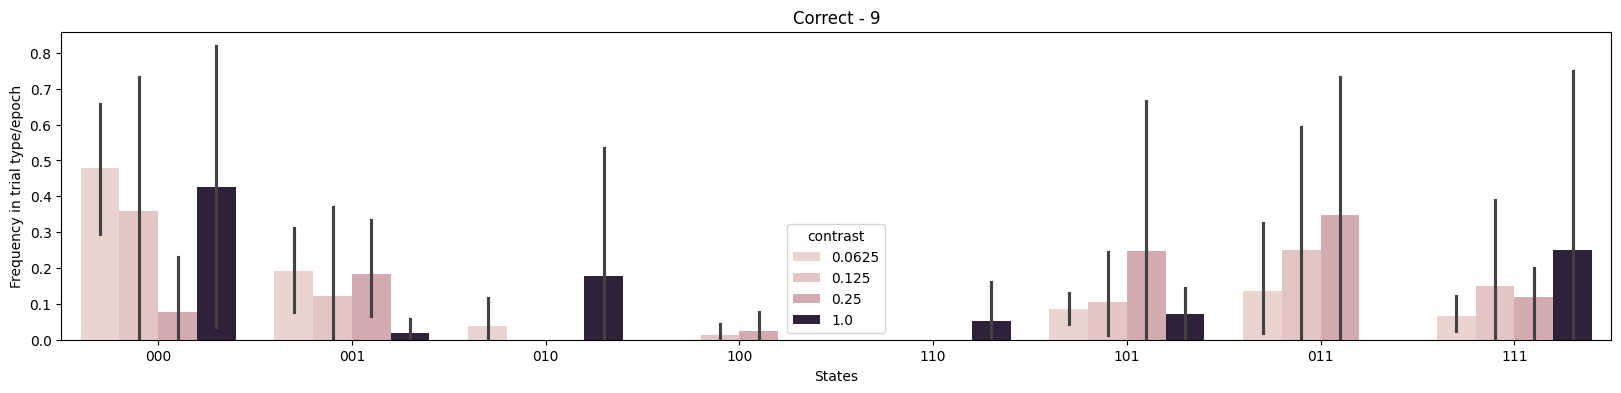

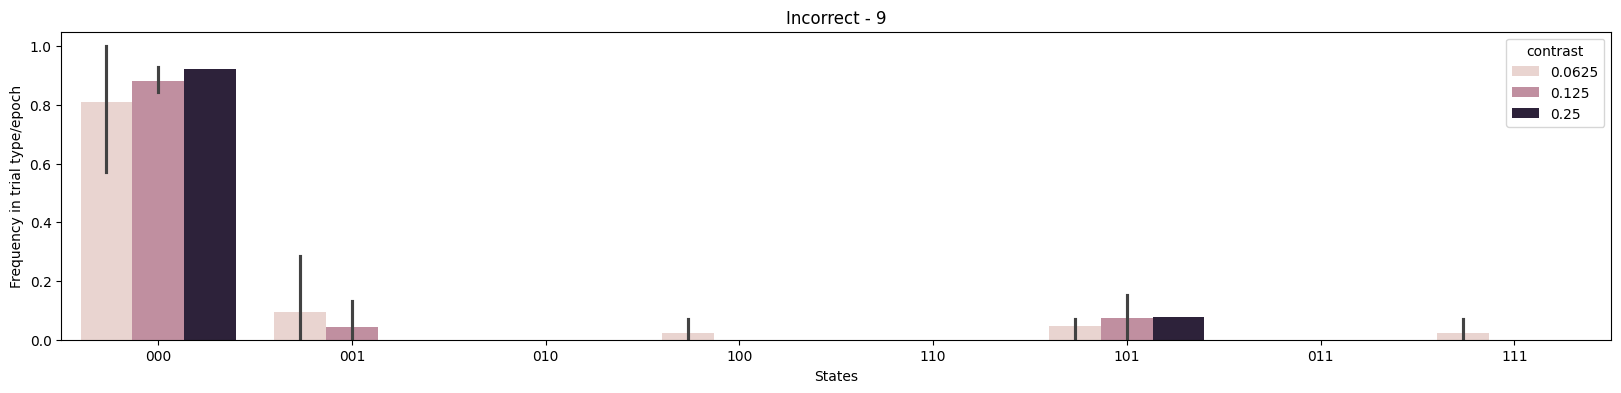

In [89]:
trial_epoch = np.unique(count['broader_label'])
epoch ='Stimulus'
reaction_bin = count.reaction_bin.unique()
use = count.dropna()
for b, bi in enumerate(reaction_bin):

    data = use.loc[(use['broader_label']==epoch) & (use['correct']==1.) & (use['reaction_bin']==bi)]
    # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
    plt.figure(figsize=[20, 4])
    sns.barplot(x='identifiable_states', y='relative_frequency', hue='contrast', data=data,
                order= ['000', '001', '010', '100', '110', '101', '011', '111'])
    plt.xlabel('States')
    plt.ylabel('Frequency in trial type/epoch')
    plt.title('Correct - '+str(b))
    plt.show()

    data = use.loc[(use['broader_label']==epoch) & (use['correct']==0.) & (use['reaction_bin']==bi)]
    # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
    plt.figure(figsize=[20, 4])
    sns.barplot(x='identifiable_states', y='relative_frequency', hue='contrast', data=data, 
                order= ['000', '001', '010', '100', '110', '101', '011', '111'])
    plt.xlabel('States')
    plt.ylabel('Frequency in trial type/epoch')
    plt.title('Incorrect - '+str(b))
    plt.show()


In [9]:
# Step 1: Group and count occurrences
count = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'contrast', 'broader_label', 'correct', 'identifiable_states'])['identifiable_states'].count())  #  'correct',

# Step 2: Reset index to bring the grouping columns back into the DataFrame
count = count.reset_index(level=[0, 1, 2, 3, 4])

# Rename the count column
count.rename(columns={'identifiable_states': 'count'}, inplace=True)

# Step 3: Calculate the total counts for each group of 'mouse_name', 'session', 'label'
count['total'] = count.groupby(['mouse_name', 'session', 'contrast', 'broader_label', 'correct'])['count'].transform('sum')  # 'broader_label'

# Step 4: Compute the relative frequency
count['relative_frequency'] = count['count'] / count['total']

# Drop the 'total' column if it's no longer needed
count = count.drop(columns=['total'])

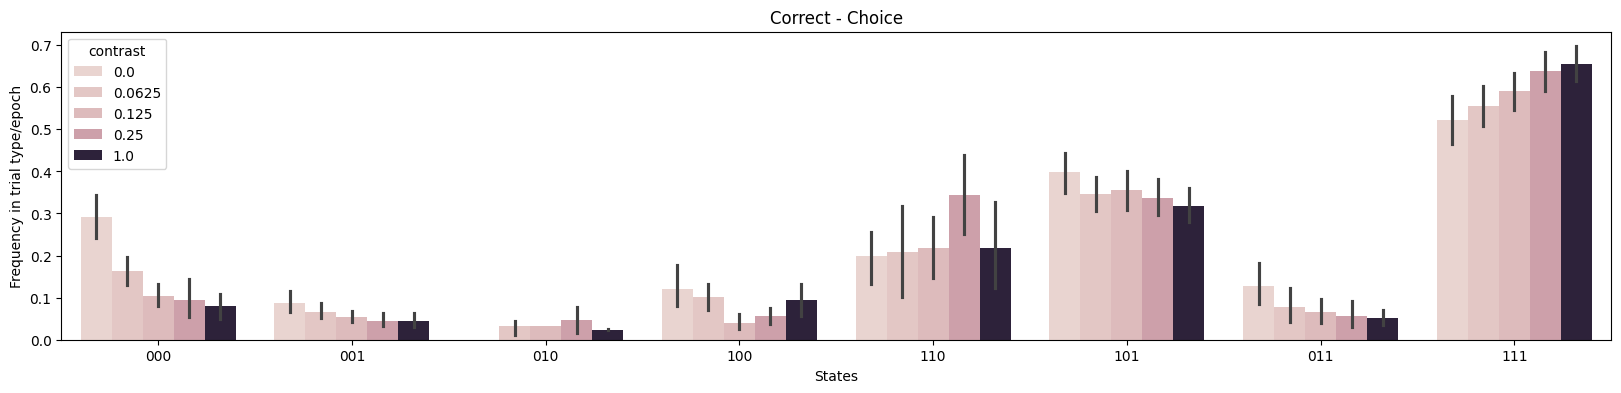

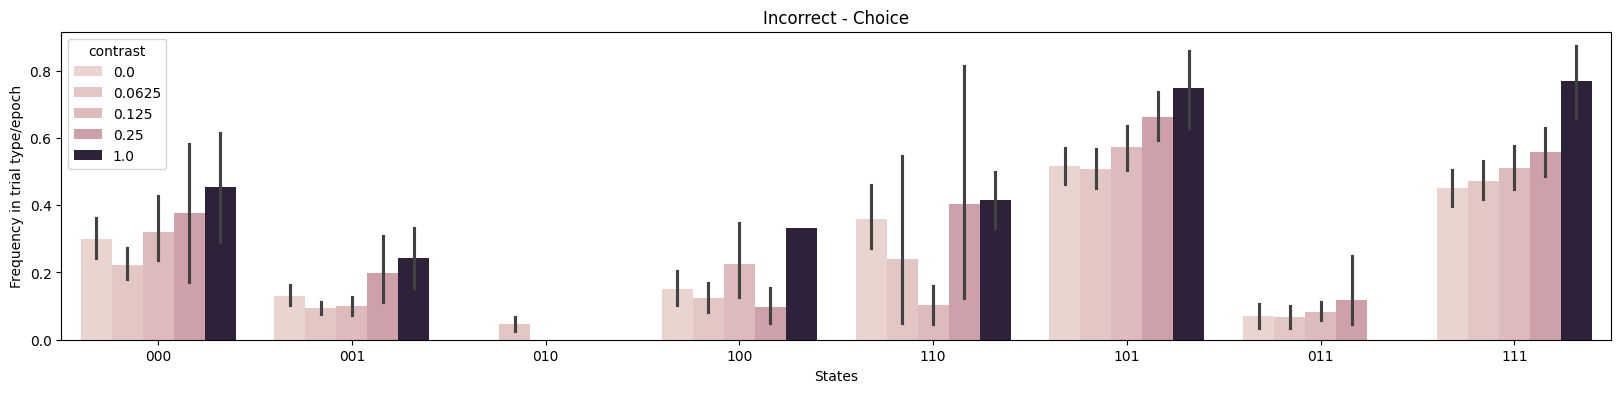

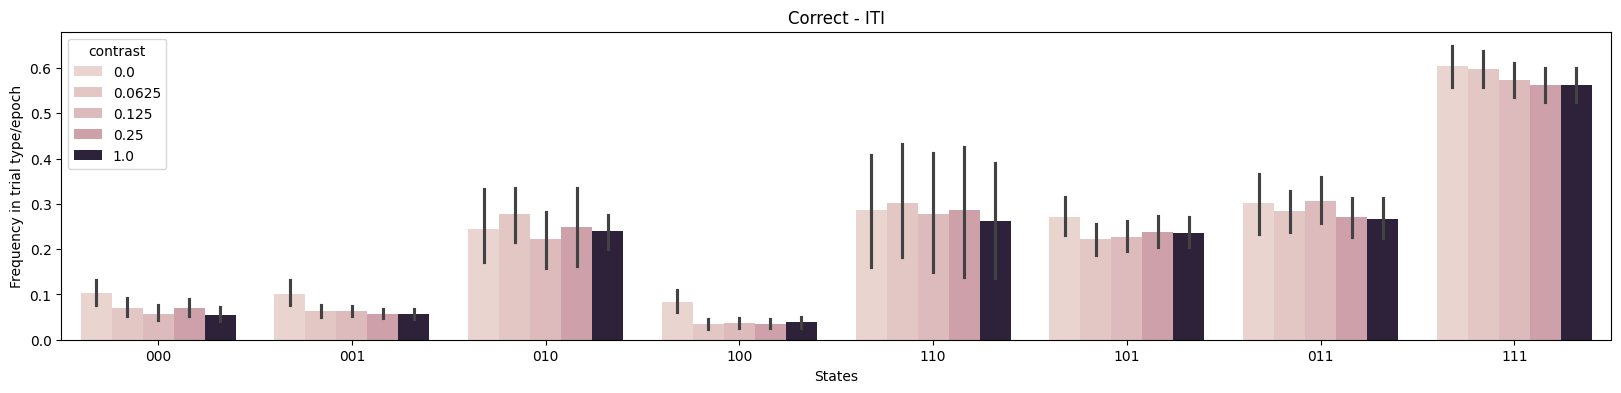

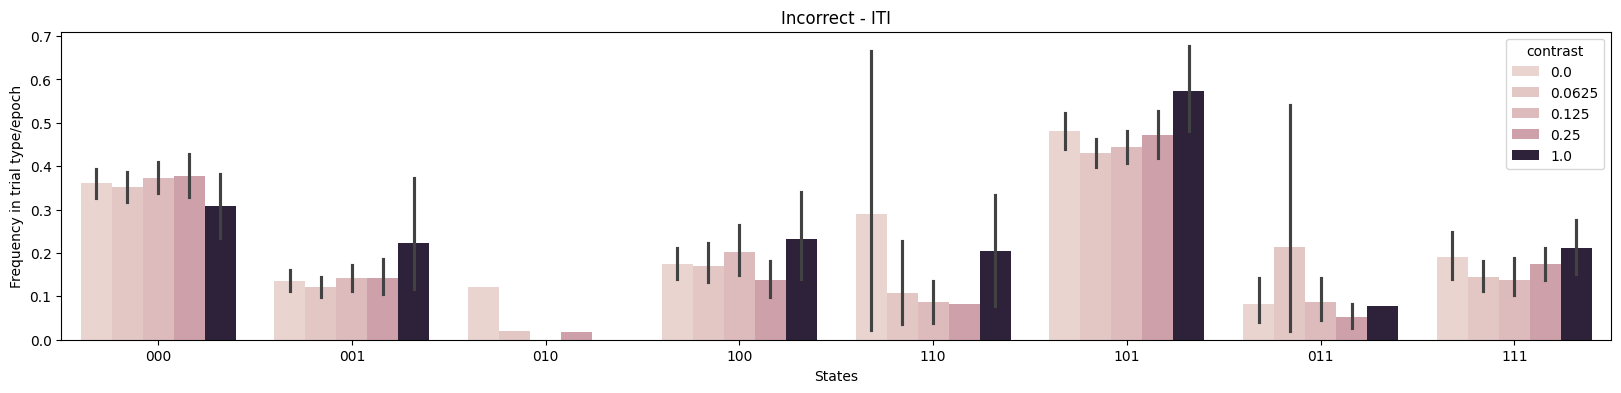

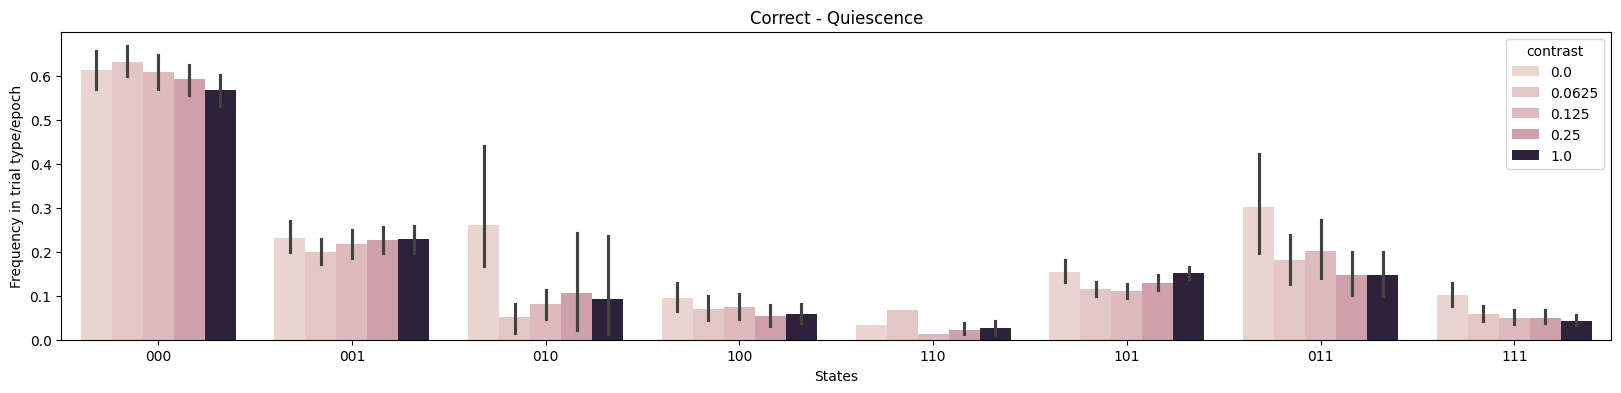

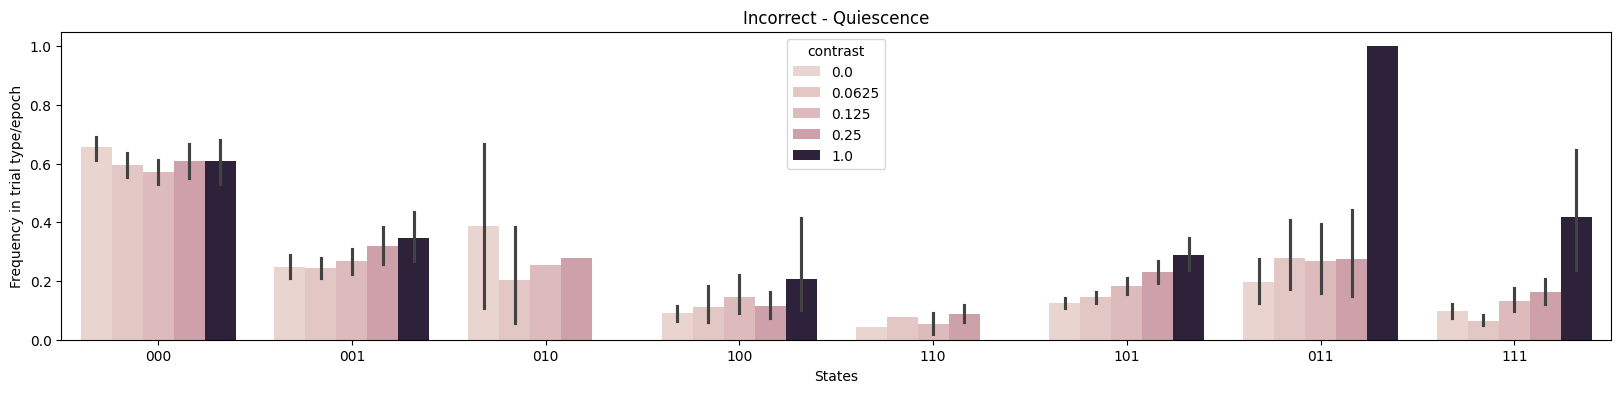

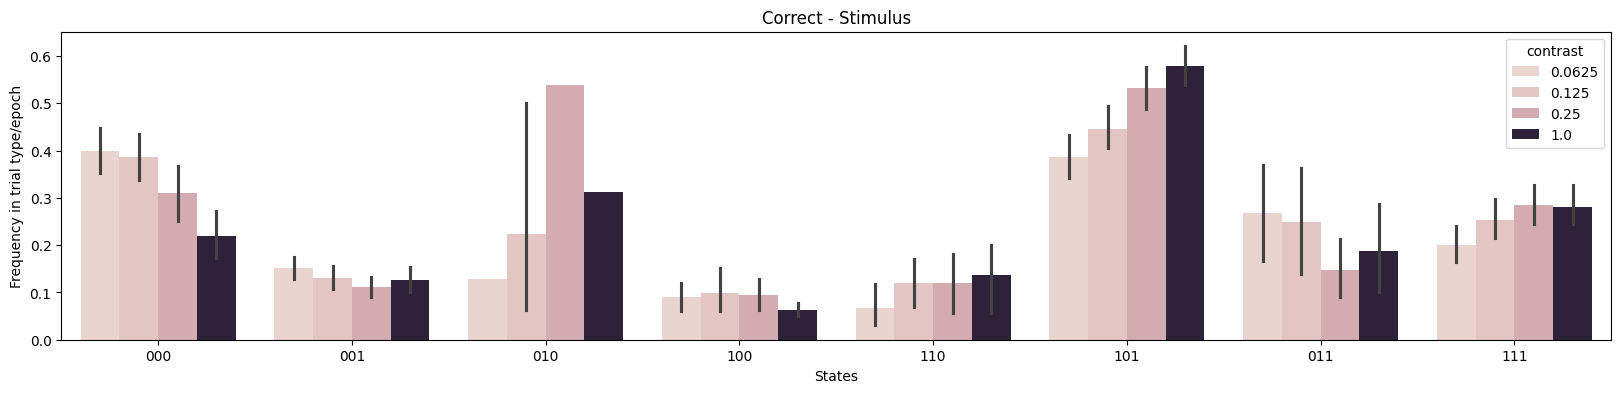

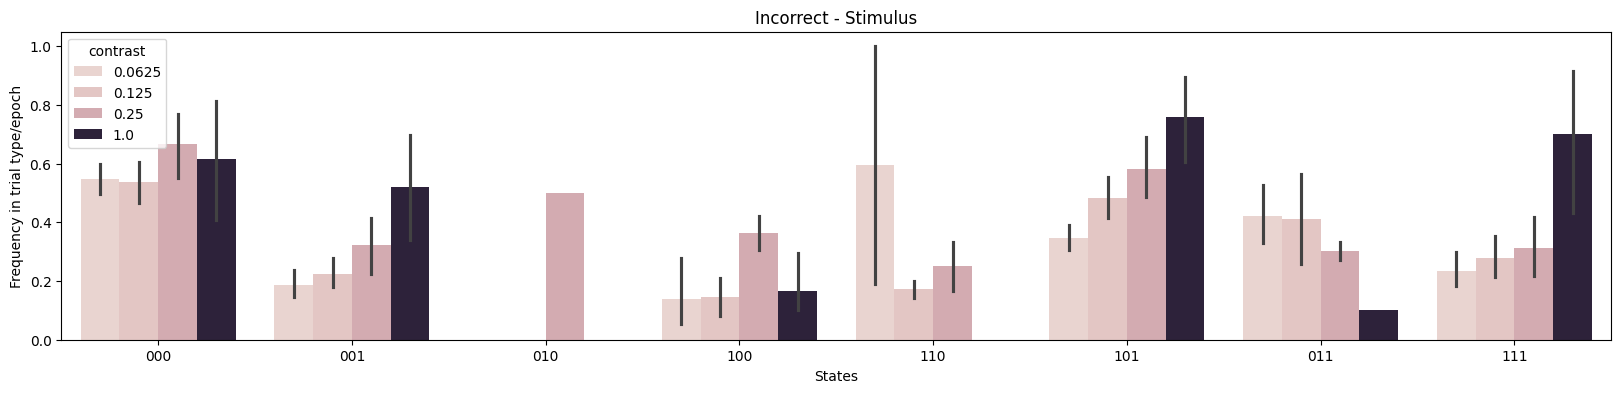

In [16]:
trial_epoch = np.unique(count['broader_label'])
epoch ='Quiescence'
contrasts = count.contrast.unique()

for epoch in trial_epoch:

    data = count.loc[(count['broader_label']==epoch) & (count['correct']==1.)]
    # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
    plt.figure(figsize=[20, 4])
    sns.barplot(hue='contrast', y='relative_frequency', x='identifiable_states', data=data, 
                order= ['000', '001', '010', '100', '110', '101', '011', '111'])
    plt.xlabel('States')
    plt.ylabel('Frequency in trial type/epoch')
    plt.title('Correct - '+epoch)
    plt.show()

    data = count.loc[(count['broader_label']==epoch) & (count['correct']==0.)]
    # data = count.loc[(count['mouse_name']=='ibl_witten_29') & (count['session']=='e9fc0a2d-c69d-44d1-9fa3-314782387cae') & (count['label']=='Quiescence')]
    plt.figure(figsize=[20, 4])
    sns.barplot(hue='contrast', y='relative_frequency', x='identifiable_states', data=data, 
                order= ['000', '001', '010', '100', '110', '101', '011', '111'])
    plt.xlabel('States')
    plt.ylabel('Frequency in trial type/epoch')
    plt.title('Incorrect - '+epoch)
    plt.show()


In [ ]:
plt.figure(figsize=[20, 4])
sns.barplot(x='identifiable_states', y='relative_frequency', hue='identifiable_states', data=count, 
            palette='viridis', hue_order= ['000', '001', '010', '100', '110', '101', '011', '111'])

In [22]:
# Step 1: Group and count occurrences
count = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'broader_label', 'identifiable_states'])['identifiable_states'].count())  #  'correct',

# Step 2: Reset index to bring the grouping columns back into the DataFrame
count = count.reset_index(level=[0, 1, 2])

# Rename the count column
count.rename(columns={'identifiable_states': 'count'}, inplace=True)

# Step 3: Calculate the total counts for each group of 'mouse_name', 'session', 'label'
count['total'] = count.groupby(['mouse_name', 'session','broader_label'])['count'].transform('sum')  # 'broader_label'

# Step 4: Compute the relative frequency
count['relative_frequency'] = count['count'] / count['total']

# Drop the 'total' column if it's no longer needed
count = count.drop(columns=['total'])

Text(0, 0.5, 'Relative frequency')

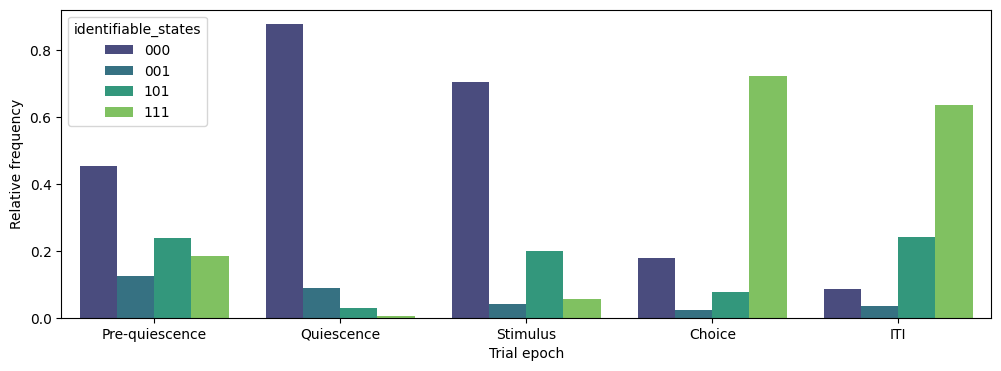

In [23]:
plt.figure(figsize=[12, 4])
data = count.loc[(count['mouse_name']=='ZM_3003') & (count['session']=='934dd7a4-fbdc-459c-8830-04fe9033bc28')]
sns.barplot(x='broader_label', y='relative_frequency', hue='identifiable_states', 
            data=data, order =  ['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI'], palette='viridis') # , hue_order=['000', '001', '101', '111']
plt.xlabel('Trial epoch')
plt.ylabel('Relative frequency')

In [10]:
# Step 1: Group and count occurrences
count = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'correct', 'broader_label', 'identifiable_states'])['identifiable_states'].count())  #  'correct',

# Step 2: Reset index to bring the grouping columns back into the DataFrame
count = count.reset_index(level=[0, 1, 2, 3])

# Rename the count column
count.rename(columns={'identifiable_states': 'count'}, inplace=True)

# Step 3: Calculate the total counts for each group of 'mouse_name', 'session', 'label'
count['total'] = count.groupby(['mouse_name', 'session', 'correct', 'broader_label'])['count'].transform('sum')  # 'broader_label'

# Step 4: Compute the relative frequency
count['relative_frequency'] = count['count'] / count['total']

# Drop the 'total' column if it's no longer needed
count = count.drop(columns=['total'])

Text(0, 0.5, 'Relative frequency')

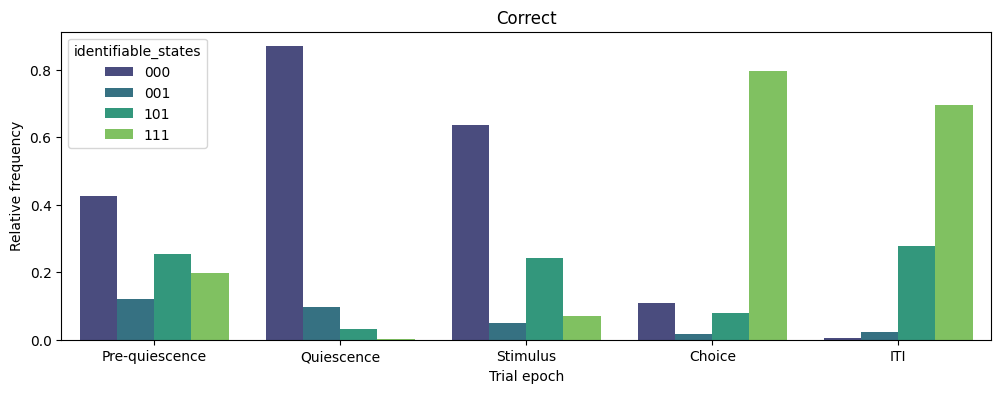

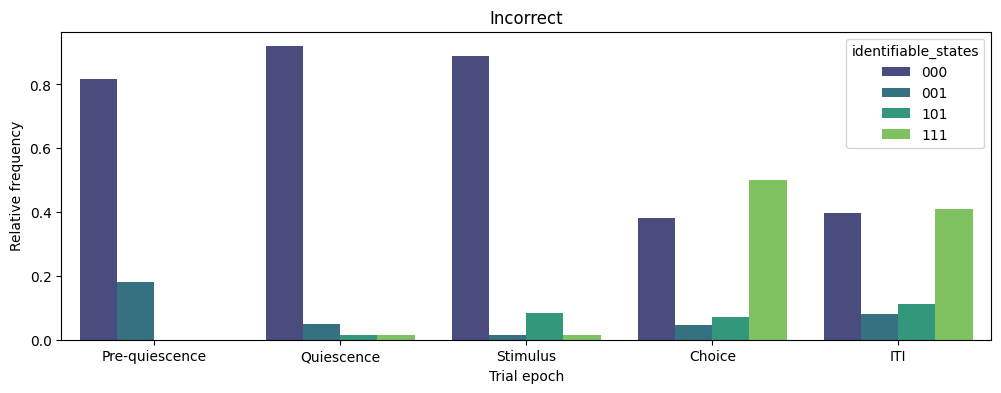

In [18]:
plt.figure(figsize=[12, 4])
data = count.loc[(count['mouse_name']=='ZM_3003') & (count['session']=='934dd7a4-fbdc-459c-8830-04fe9033bc28')
                 & (count['correct']==1.)]
sns.barplot(x='broader_label', y='relative_frequency', hue='identifiable_states', 
            data=data, order =  ['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI'], palette='viridis') # , hue_order=['000', '001', '101', '111']
plt.title('Correct')
plt.xlabel('Trial epoch')
plt.ylabel('Relative frequency')
plt.figure(figsize=[12, 4])
data = count.loc[(count['mouse_name']=='ZM_3003') & (count['session']=='934dd7a4-fbdc-459c-8830-04fe9033bc28')
                 & (count['correct']==0.)]
sns.barplot(x='broader_label', y='relative_frequency', hue='identifiable_states', 
            data=data, order =  ['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI'], palette='viridis') 
plt.title('Incorrect')
plt.xlabel('Trial epoch')
plt.ylabel('Relative frequency')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/_base.py:1007: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_data.insert(0, var, comp_col)


ValueError: cannot reindex on an axis with duplicate labels

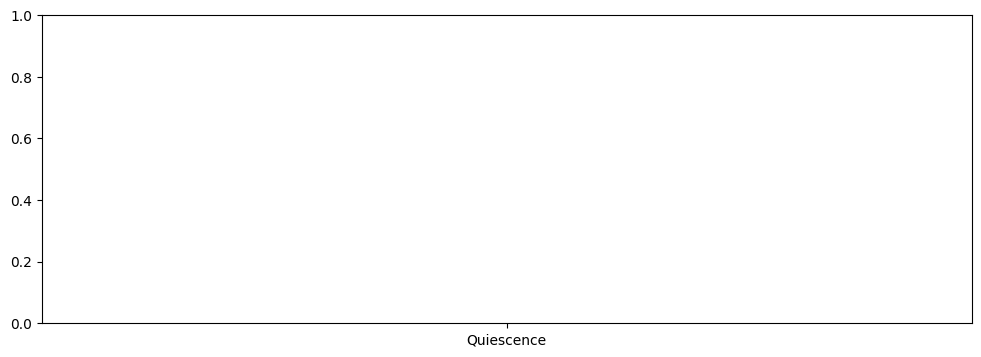

In [11]:
plt.figure(figsize=[12, 4])
data = count.loc[(count['mouse_name']=='ZM_3003') & (count['session']=='934dd7a4-fbdc-459c-8830-04fe9033bc28')
                 & (count['correct']==1.)]
sns.barplot(x='broader_label', y='relative_frequency', hue='identifiable_states', 
            data=data, order =  ['Quiescence', 'Stimulus', 'Choice', 'ITI'],
            hue_order=['000', '001', '101', '111'])
plt.title('Correct')
plt.figure(figsize=[12, 4])
data = count.loc[(count['mouse_name']=='ZM_3003') & (count['session']=='934dd7a4-fbdc-459c-8830-04fe9033bc28')
                 & (count['correct']==0.)]
sns.barplot(x='broader_label', y='relative_frequency', hue='identifiable_states', 
            data=data, order =  ['Quiescence', 'Stimulus', 'Choice', 'ITI'],
            hue_order=['000', '001', '101', '111'])
plt.title('Incorrect')
# ['Quiescence', 'Stimulus right', 'Stimulus left', 'Left choice',
#                                 'Right choice', 'Correct feedback', 'Incorrect feedback',
#                                 'ITI_correct', 'ITI_incorrect']

In [60]:

use_data.wsls.unique()

array(['wst', 'ls', 'wsh', 'lsh'], dtype=object)

/tmp/ipykernel_23489/1033638356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


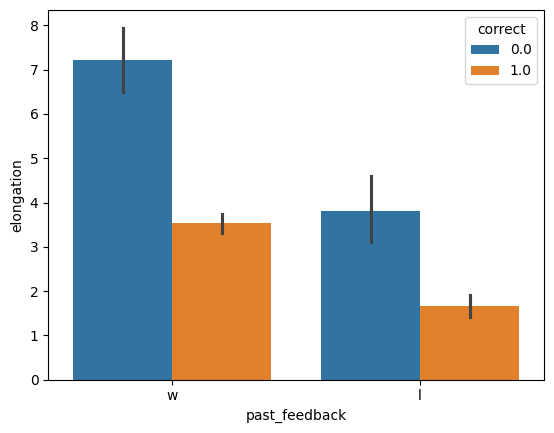

In [61]:

use_data = states_trial_type.loc[states_trial_type['session']=='7416f387-b302-4ca3-8daf-03b585a1b7ec']
use_data['past_feedback'] = use_data['wsls']
use_data.loc[use_data['wsls']=='lsh', 'past_feedback'] = 'l'
use_data.loc[use_data['wsls']=='ls', 'past_feedback'] = 'l'
use_data.loc[use_data['wsls']=='wsh', 'past_feedback'] = 'w'
use_data.loc[use_data['wsls']=='wst', 'past_feedback'] = 'w'
# use_data = session_trials
sns.barplot(y='elongation', hue='correct', x='past_feedback', data=use_data)
# plt.ylim([0, 5])
plt.show()

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


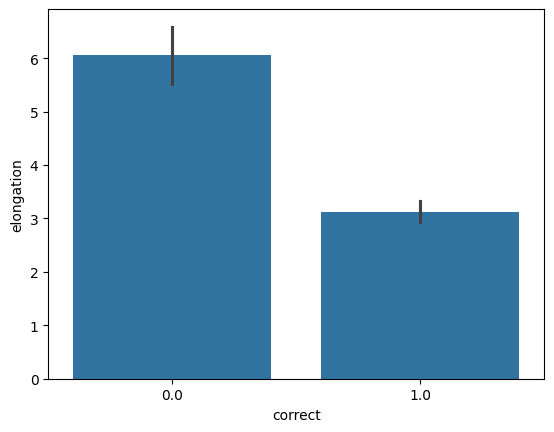

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


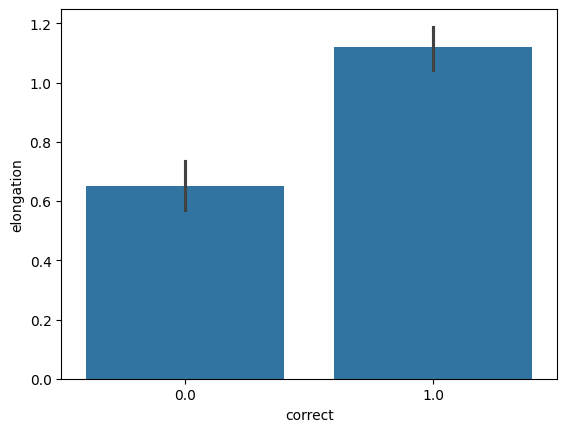

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


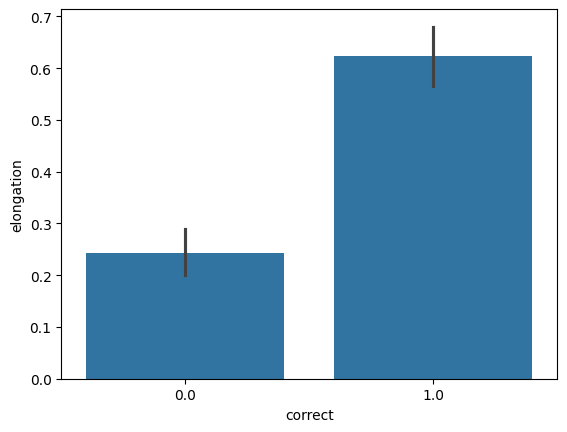

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


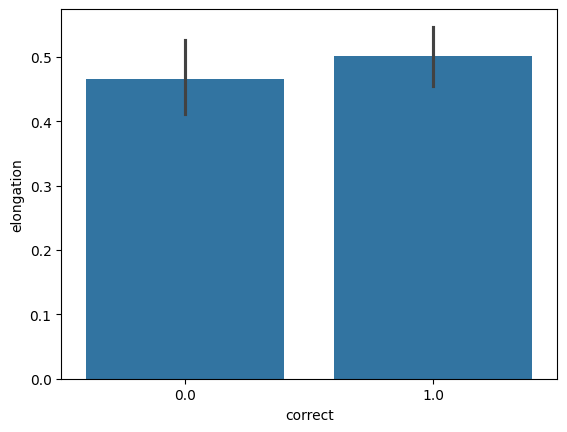

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


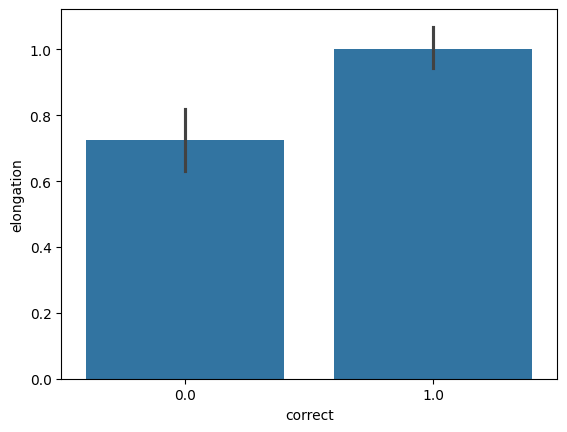

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


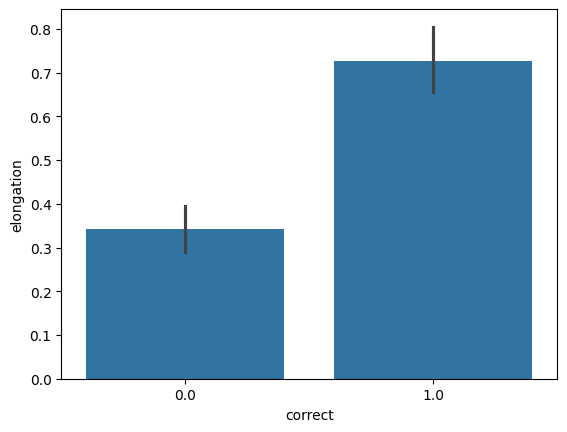

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


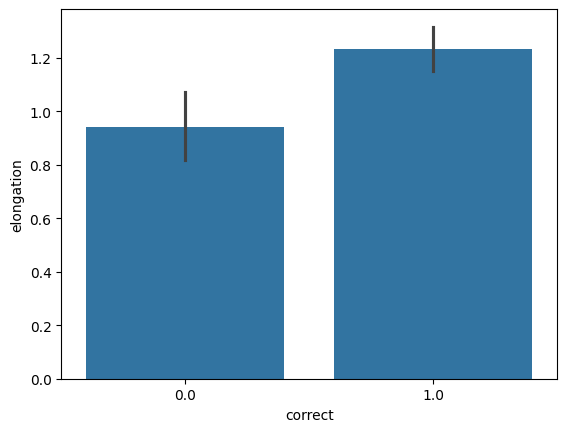

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


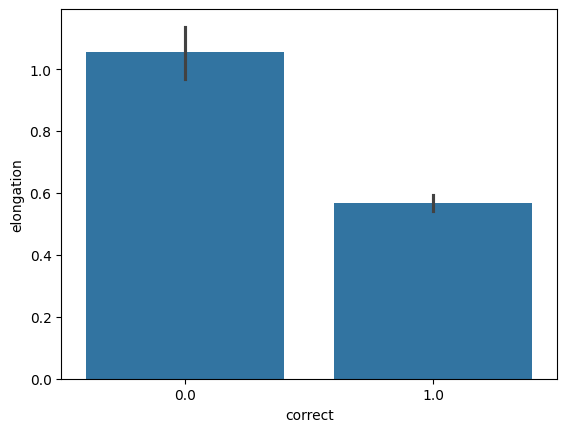

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


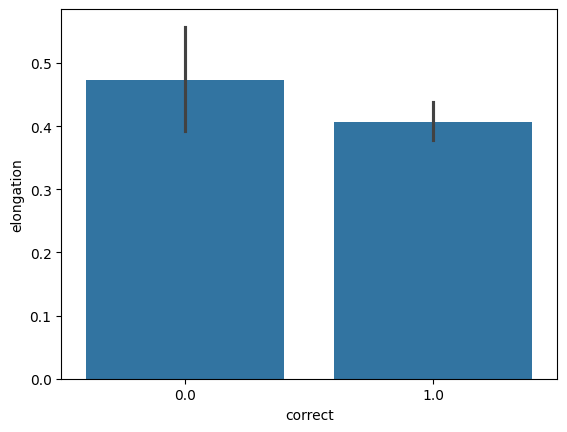

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


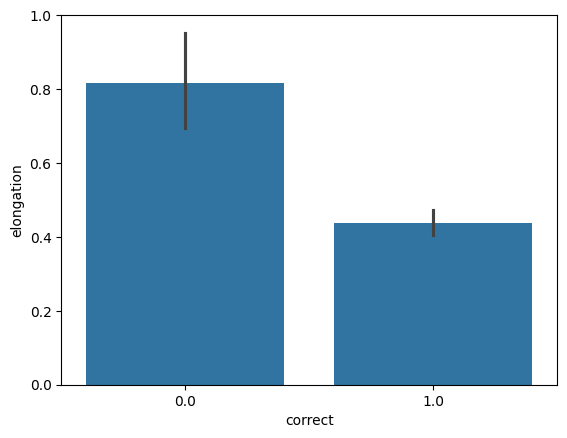

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


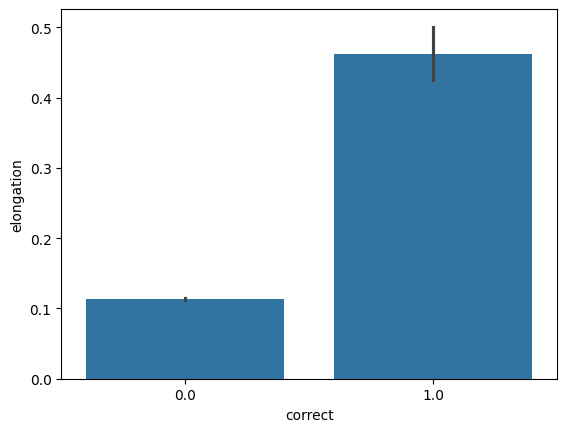

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


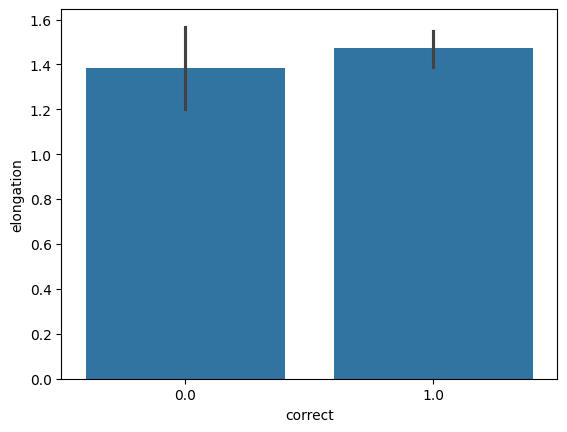

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


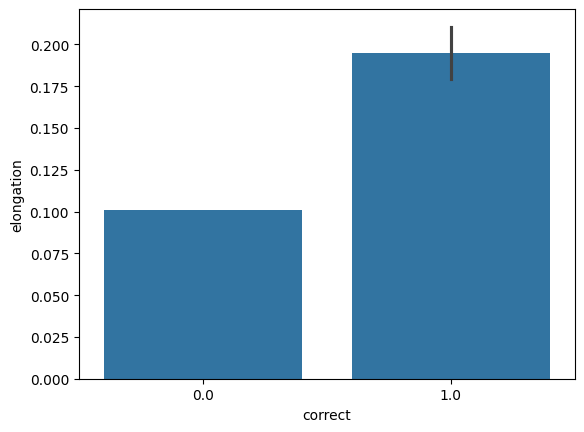

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


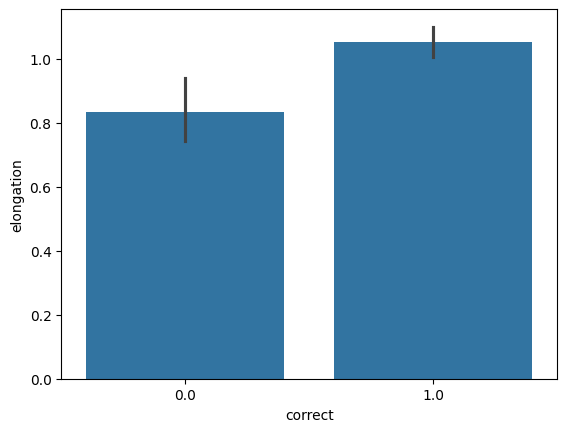

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


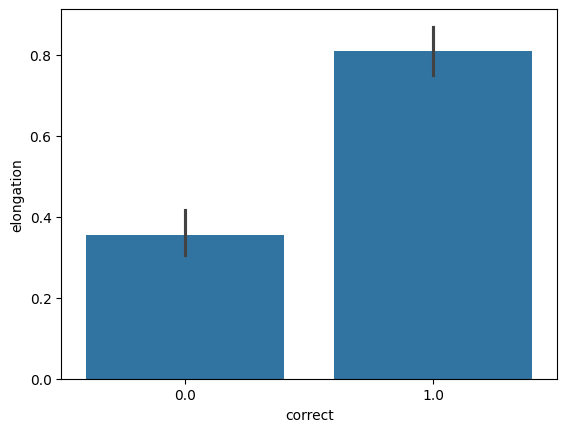

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


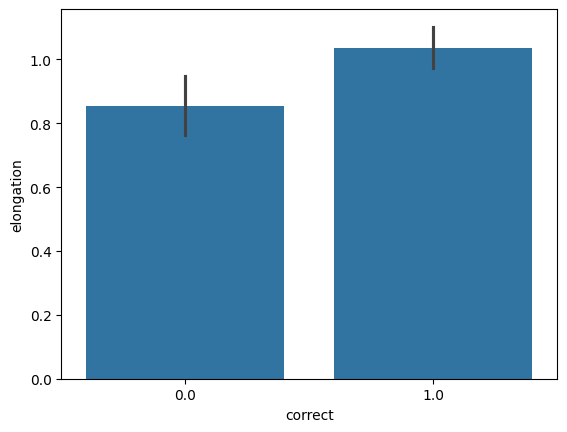

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


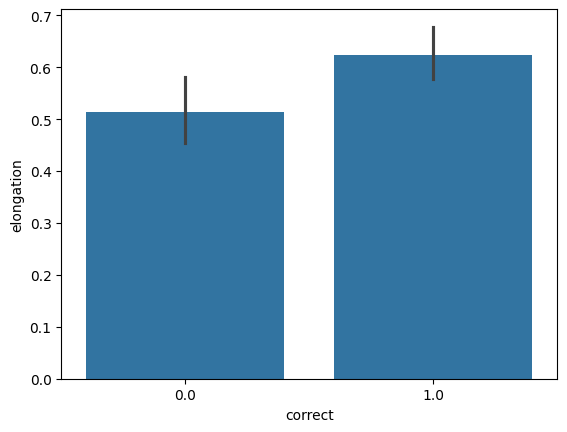

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


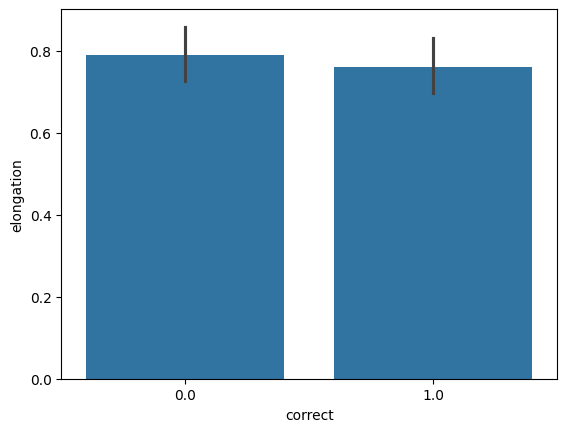

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


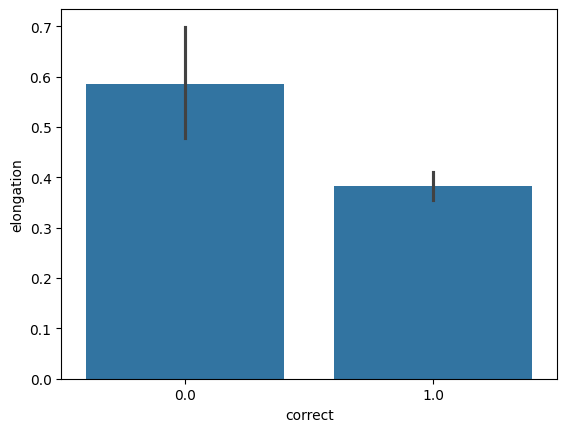

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


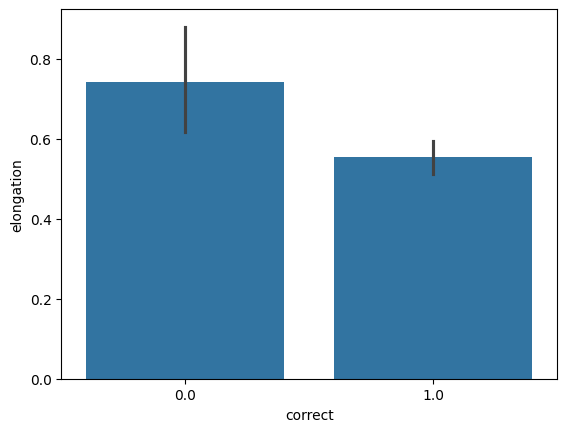

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


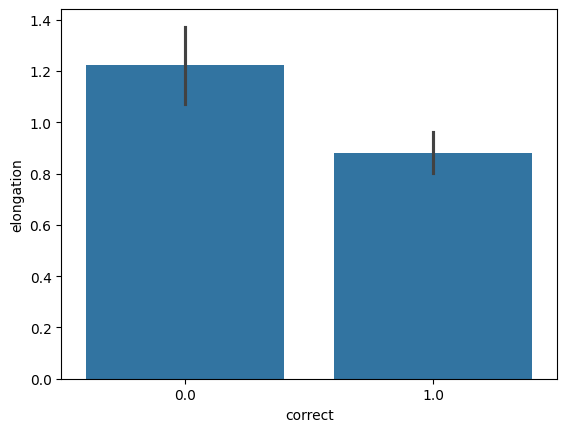

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


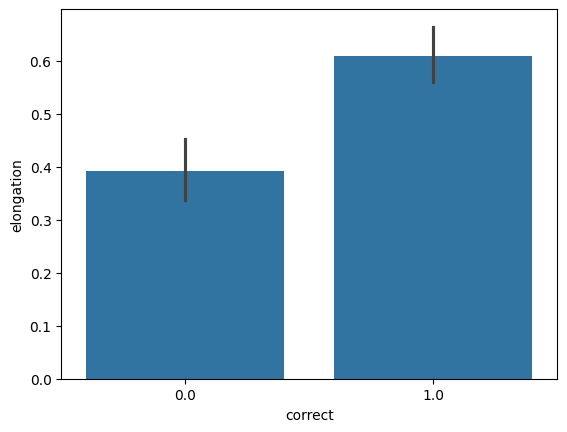

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


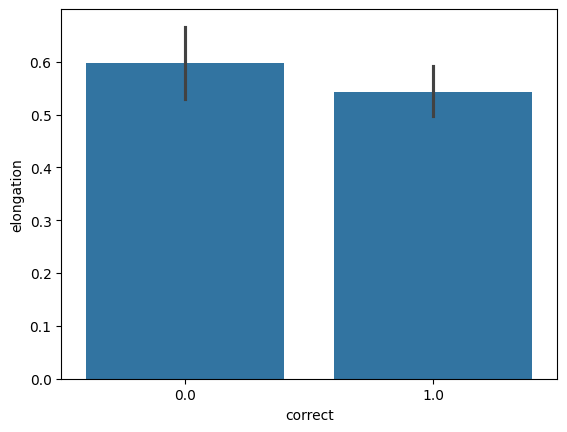

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


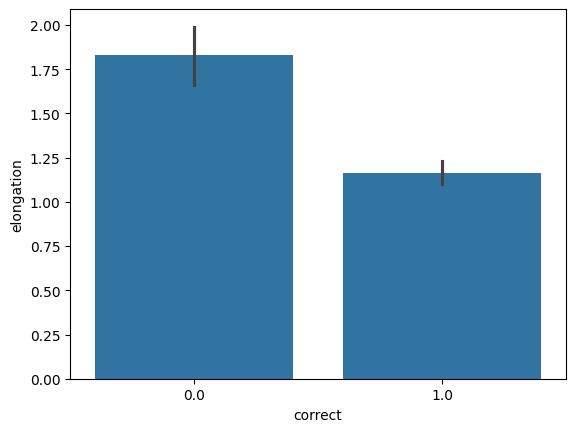

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


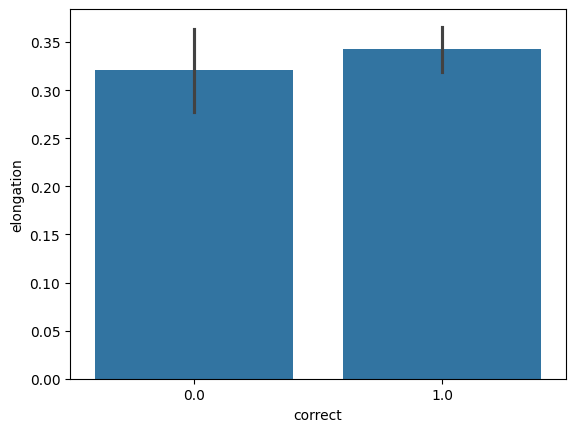

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


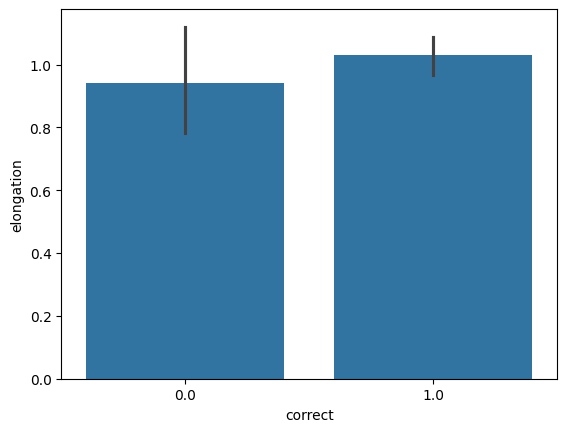

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


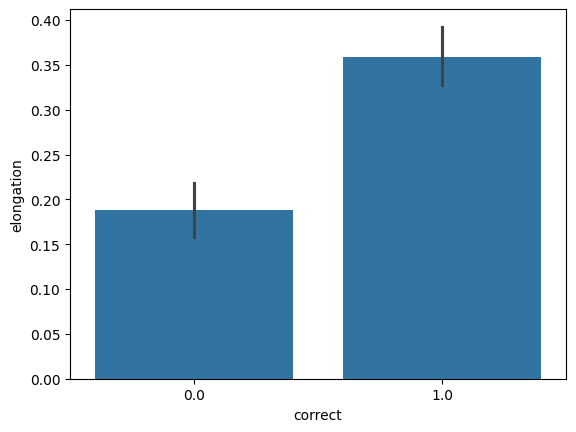

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


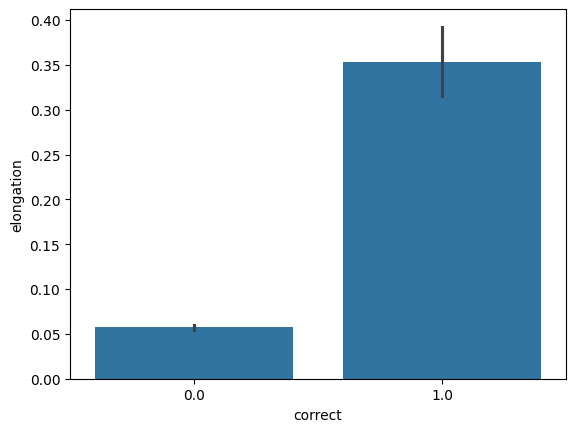

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


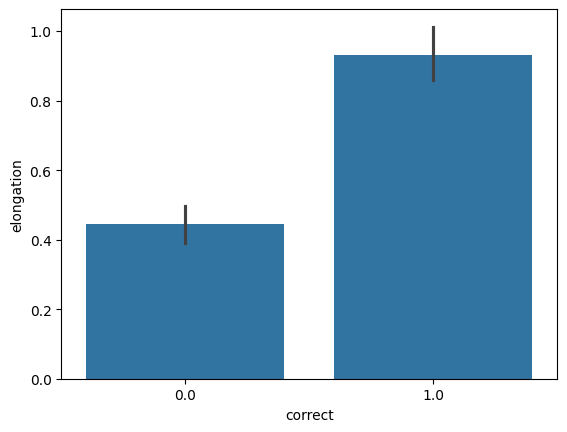

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


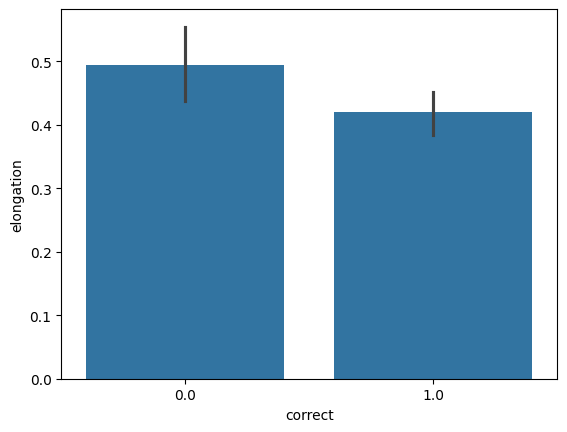

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


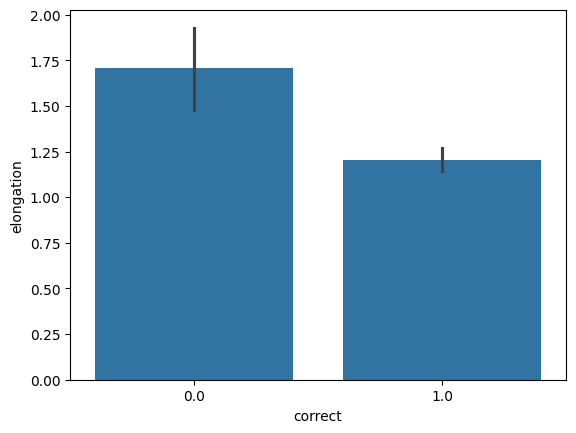

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


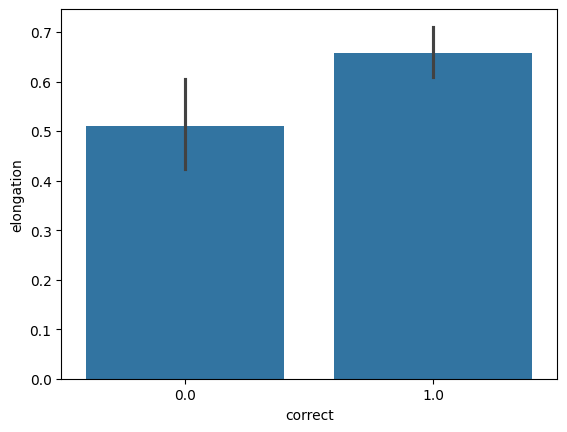

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


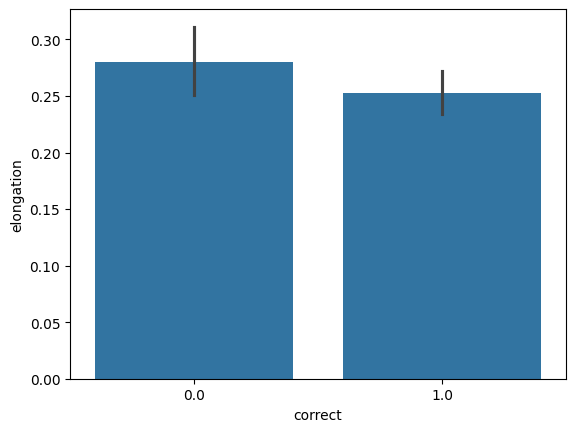

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


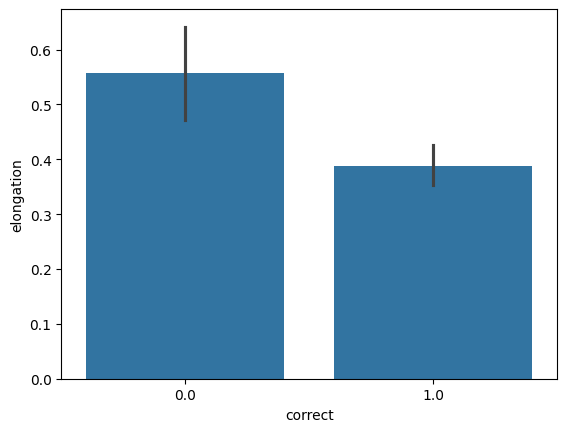

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


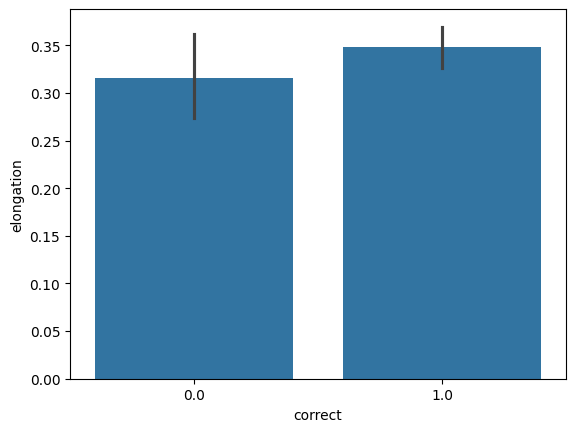

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


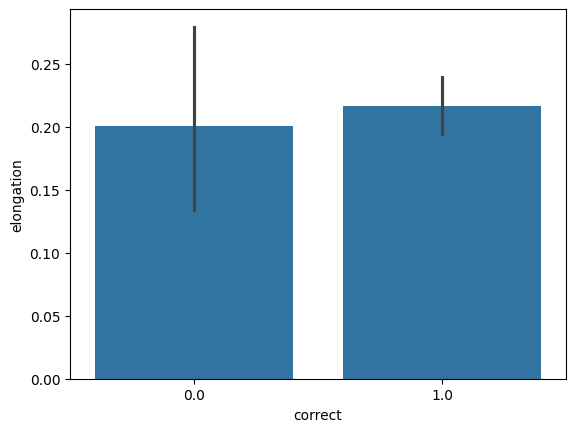

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


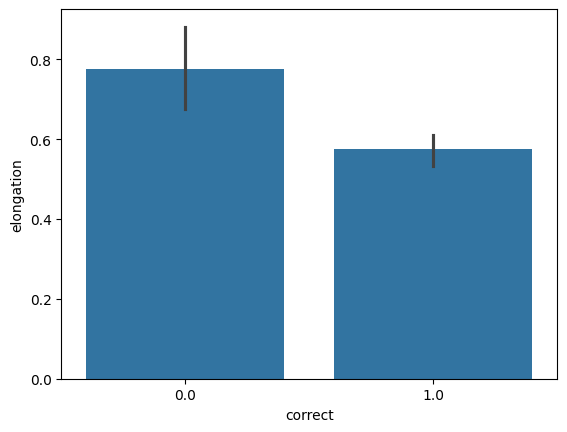

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


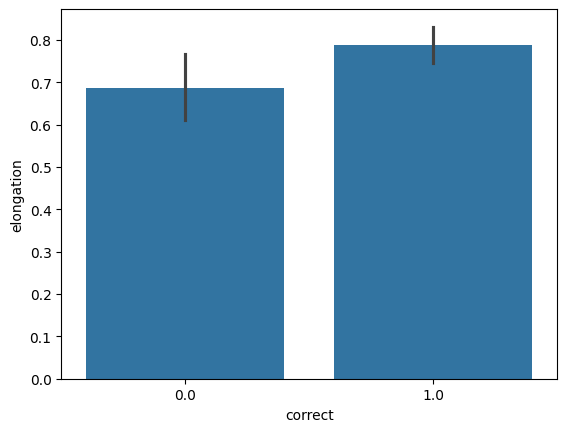

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


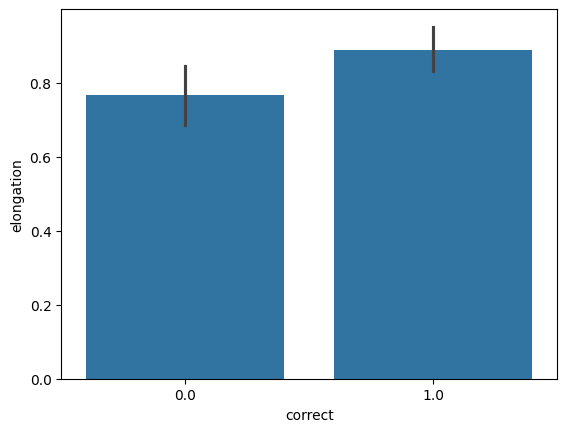

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


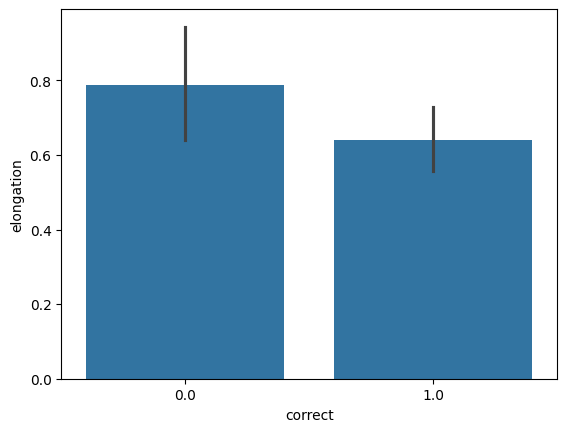

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


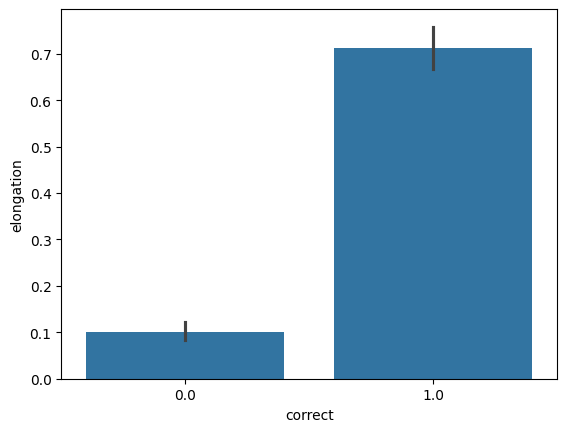

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


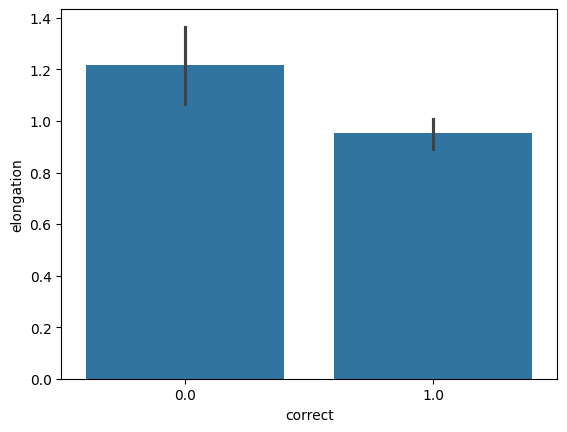

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


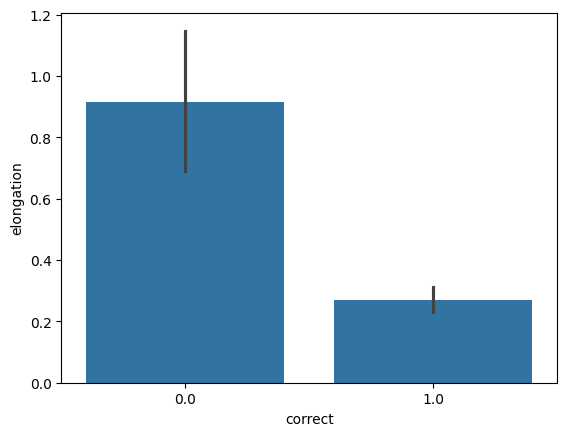

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


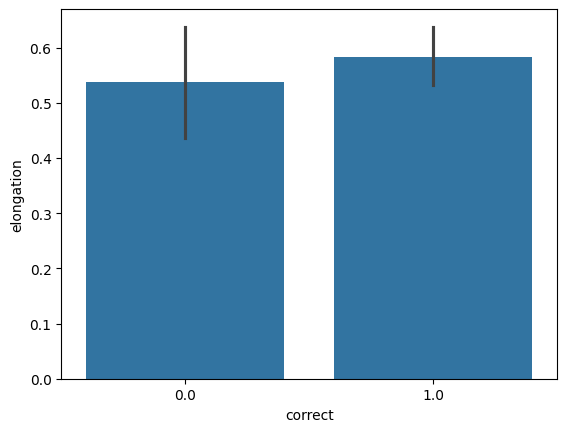

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


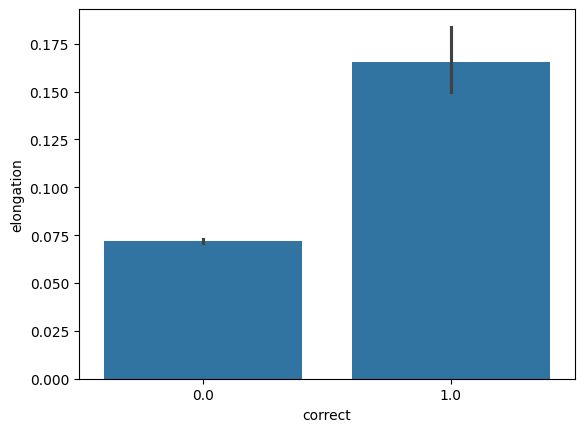

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


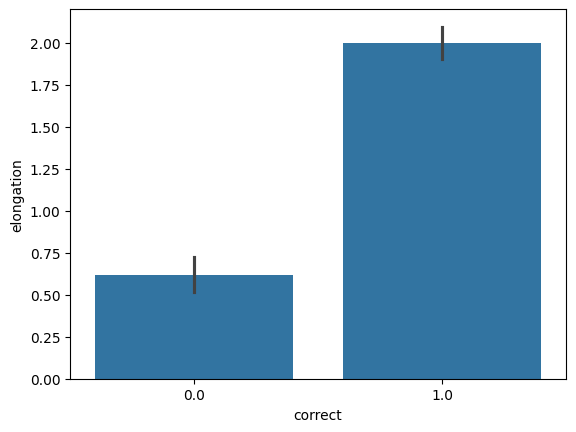

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


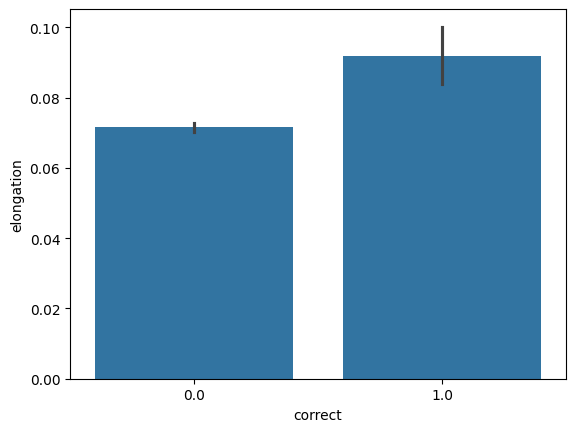

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


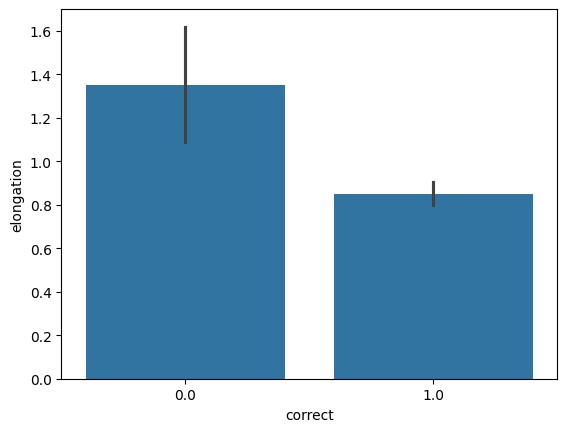

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


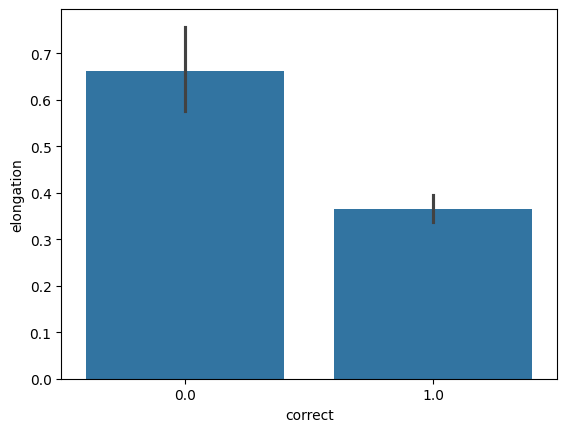

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


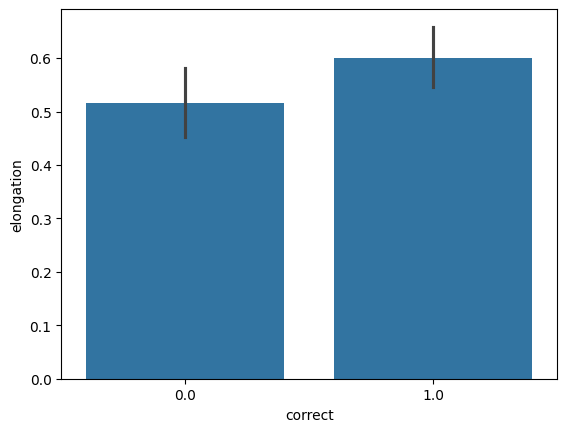

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


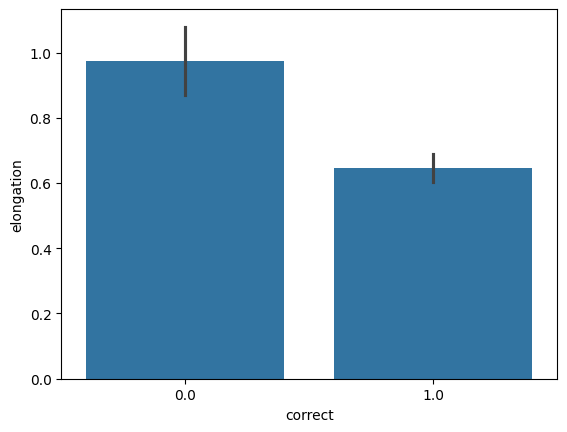

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


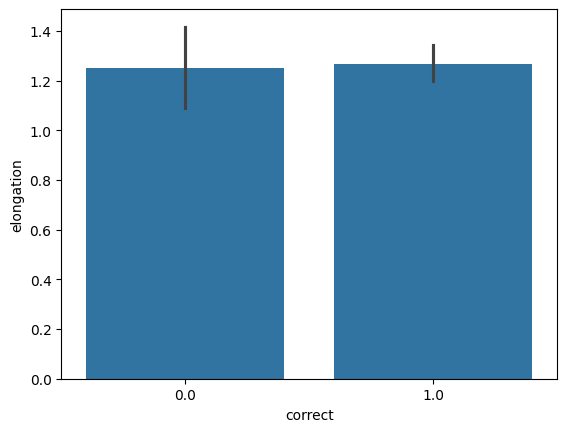

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


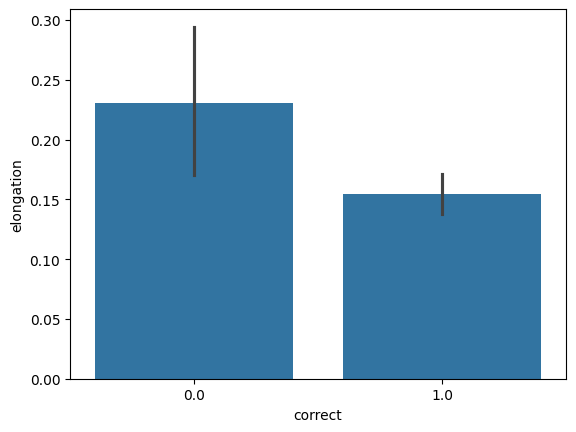

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


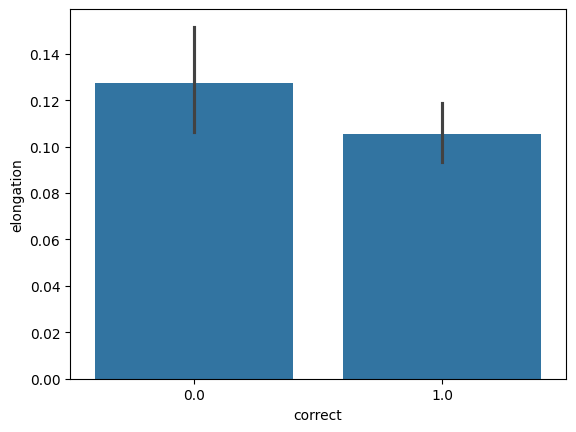

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


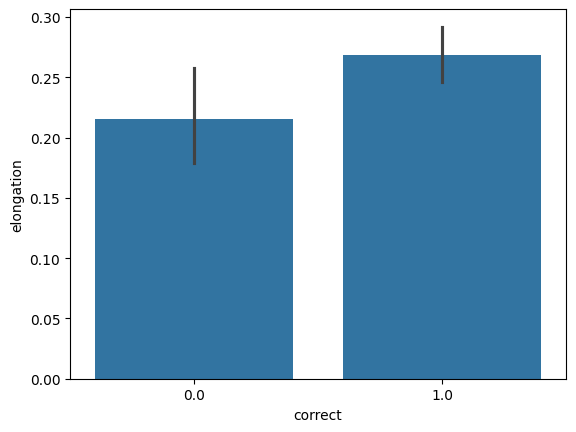

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


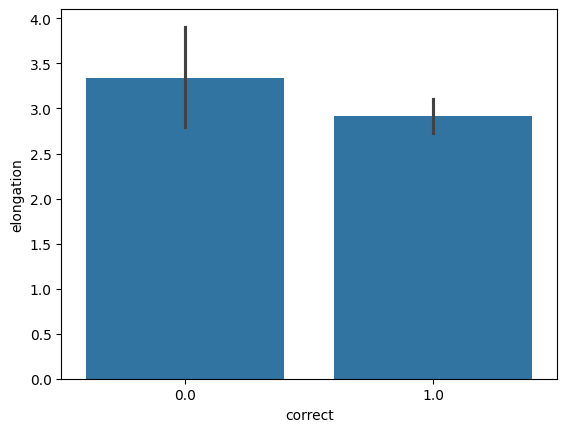

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


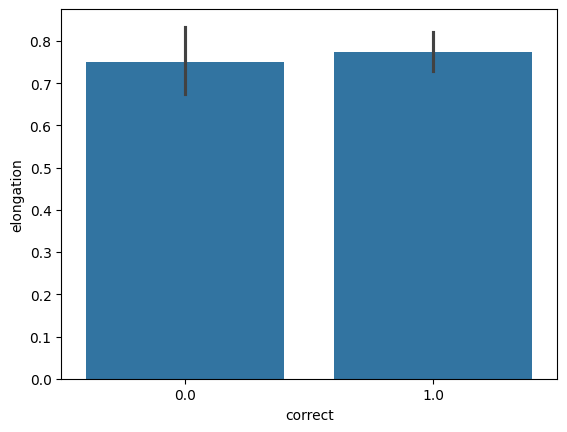

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


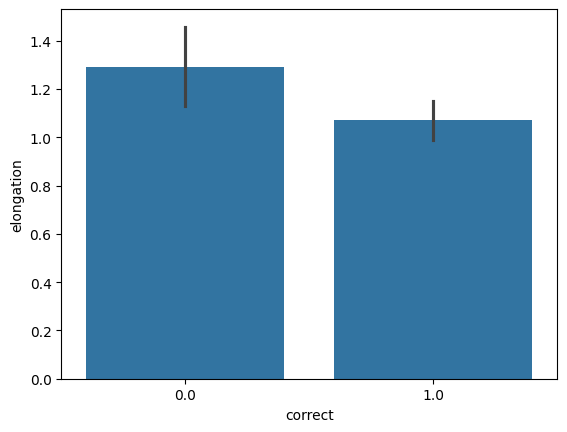

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


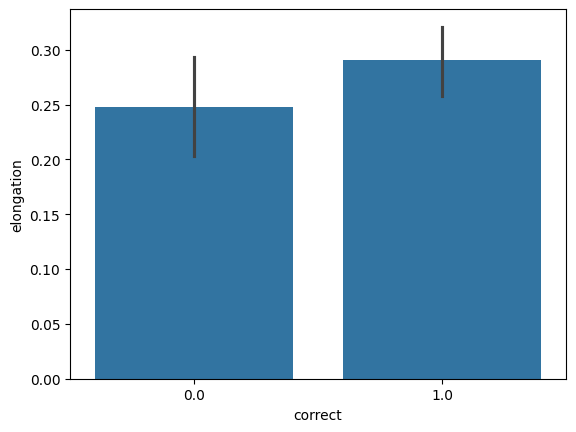

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


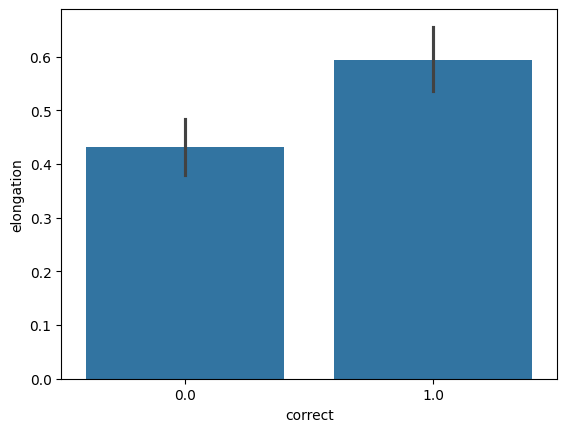

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


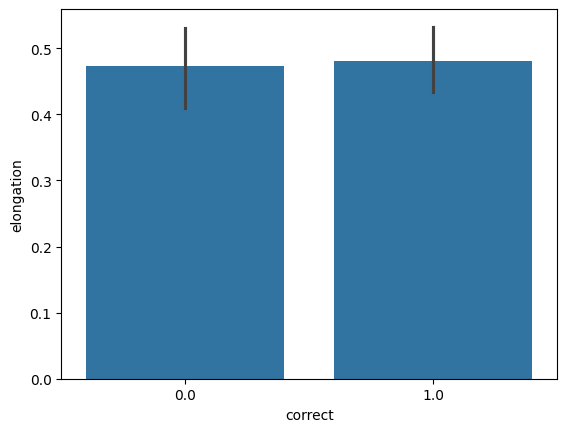

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


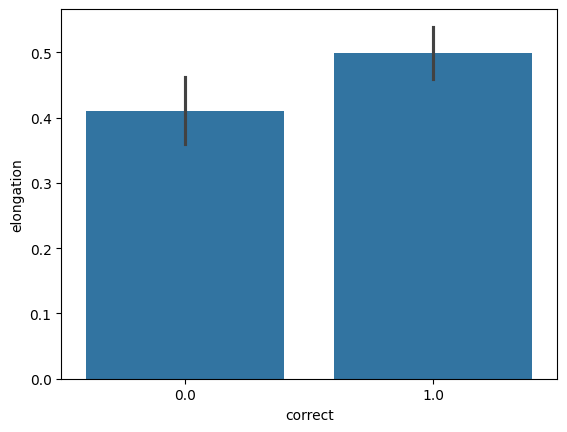

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


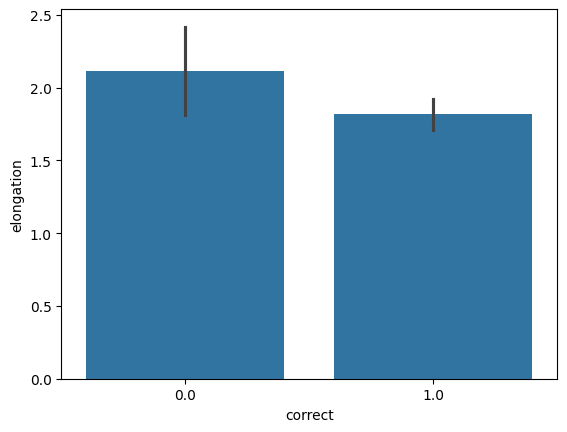

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


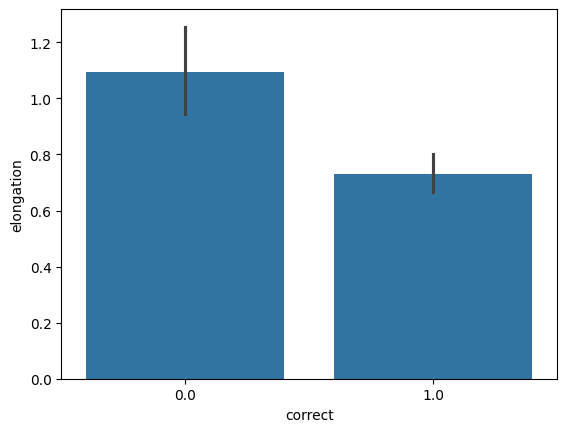

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


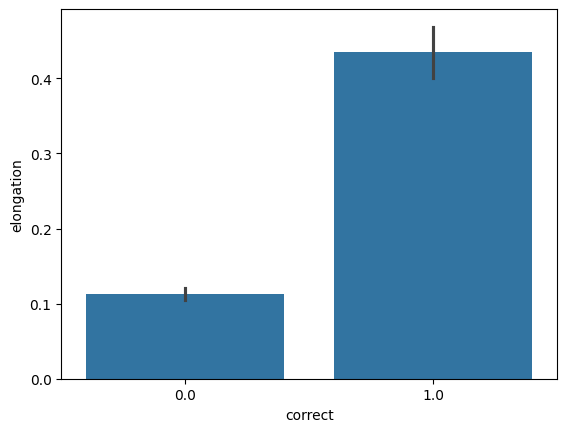

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


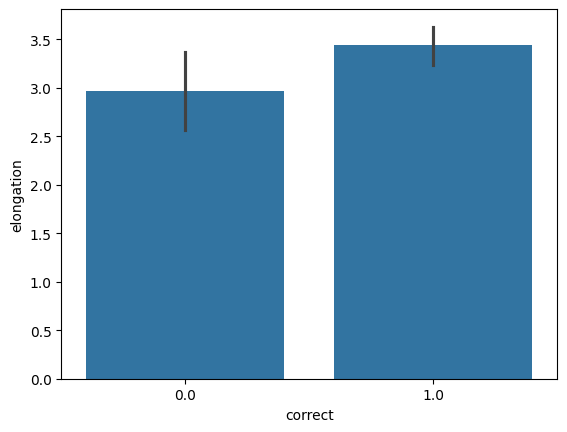

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


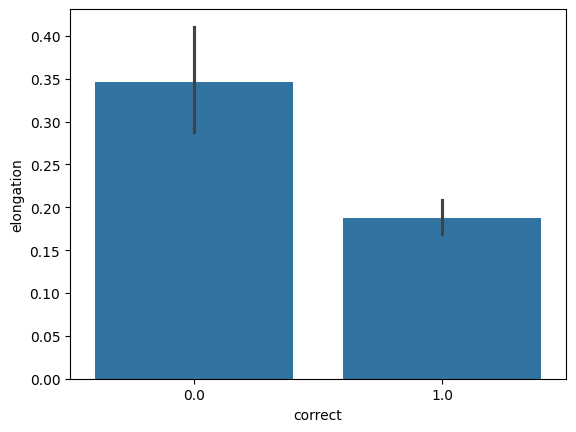

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


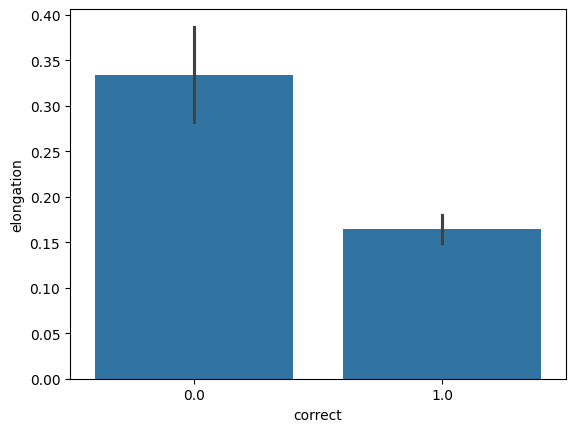

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


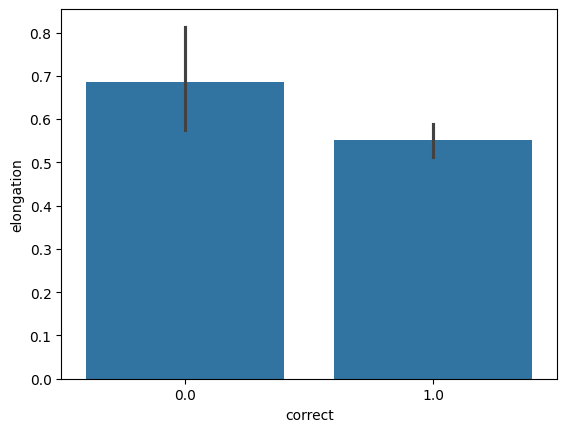

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


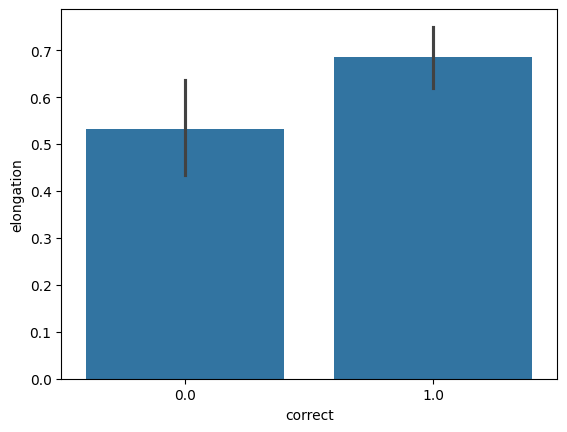

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


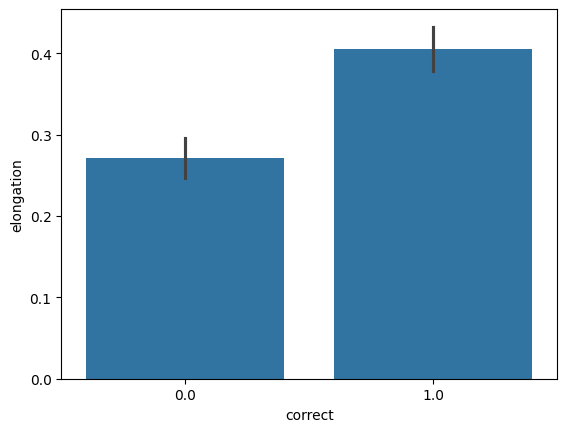

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


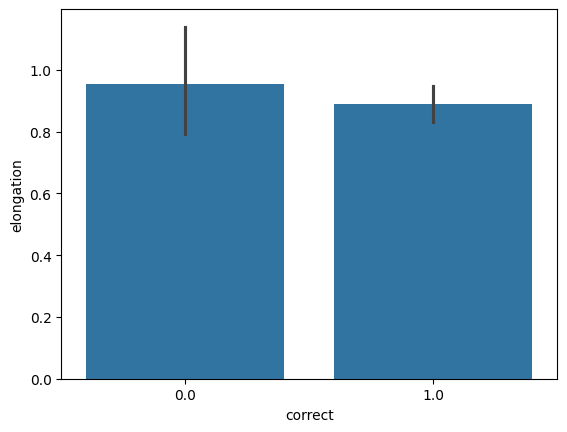

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


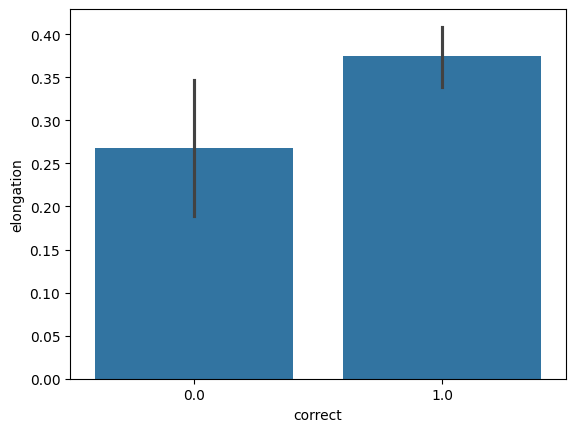

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


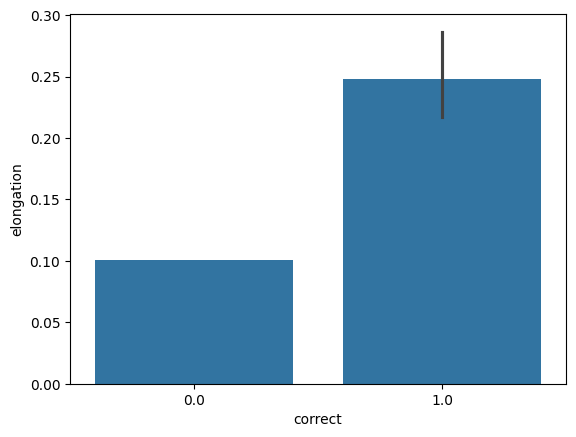

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


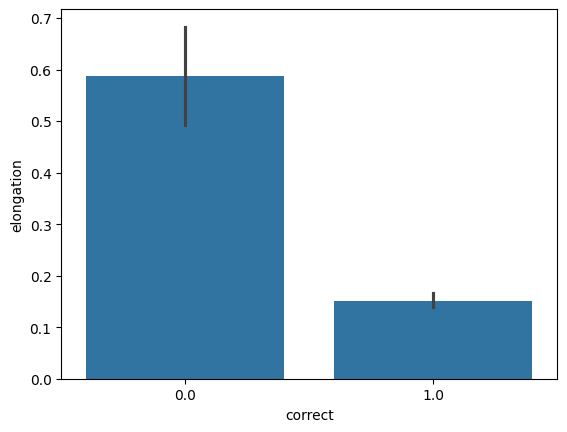

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


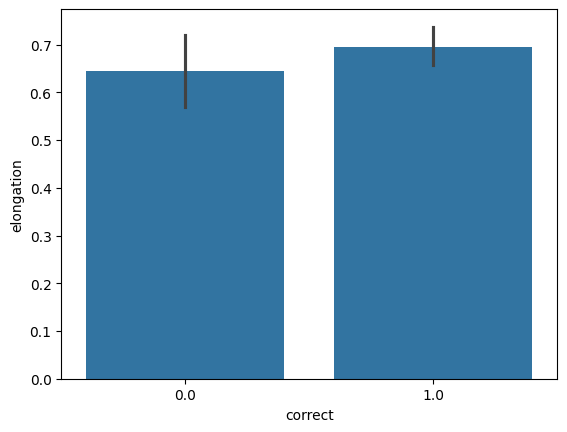

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


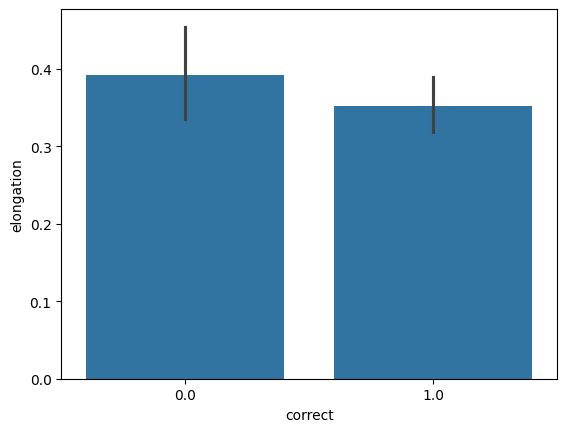

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


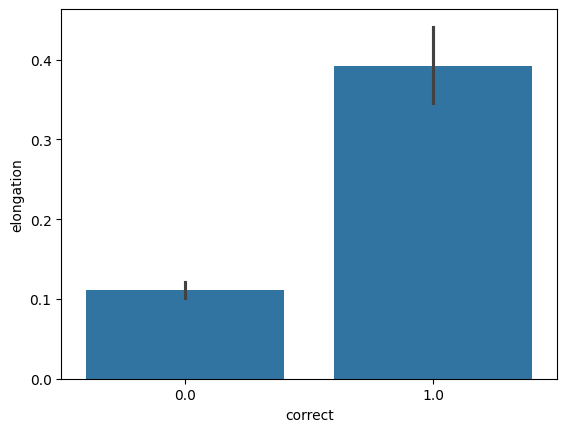

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


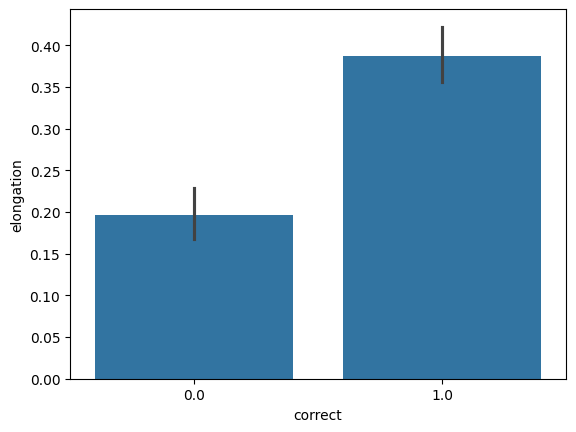

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


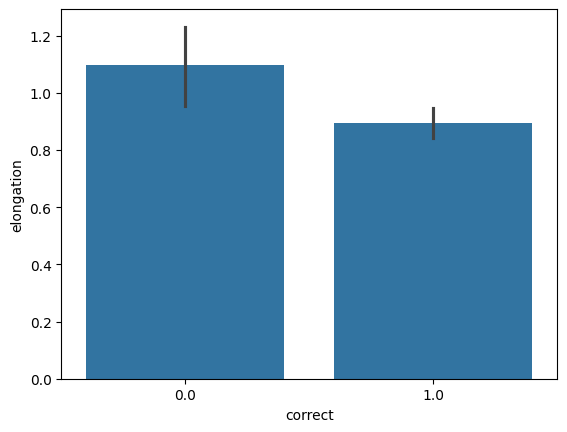

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


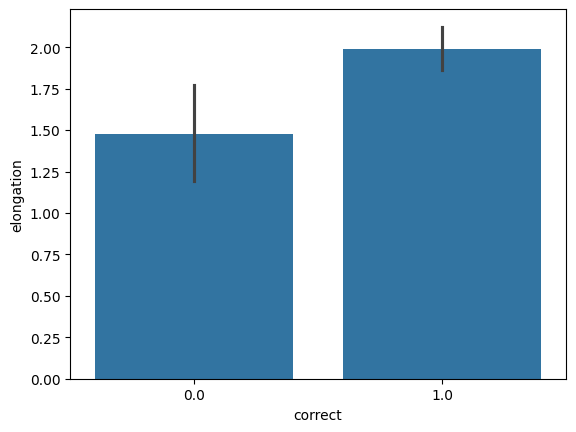

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


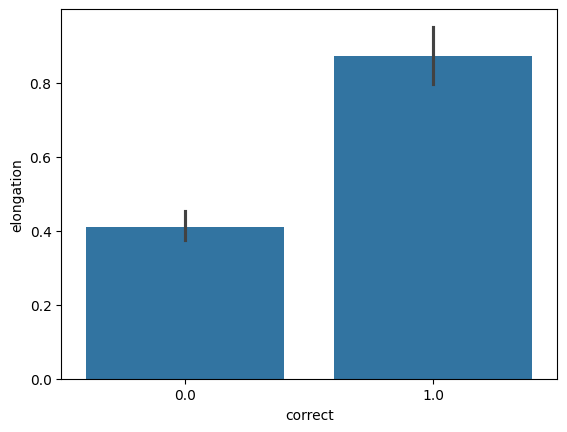

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


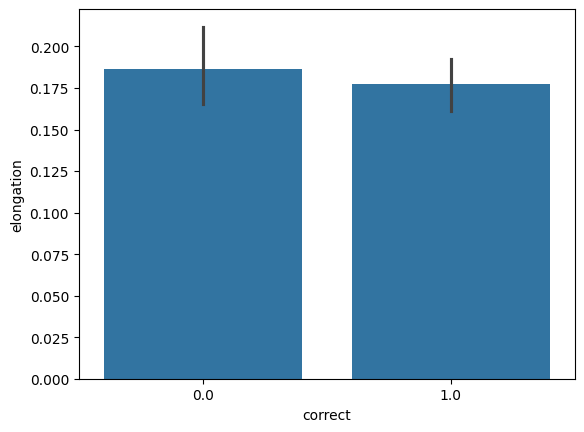

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


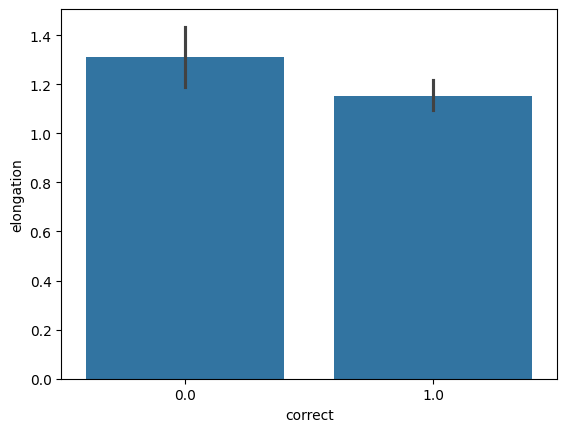

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


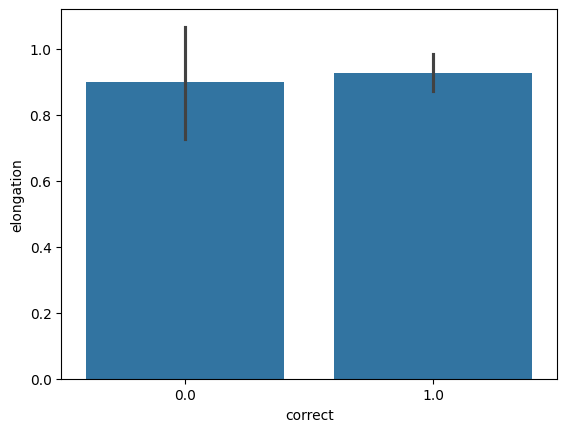

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


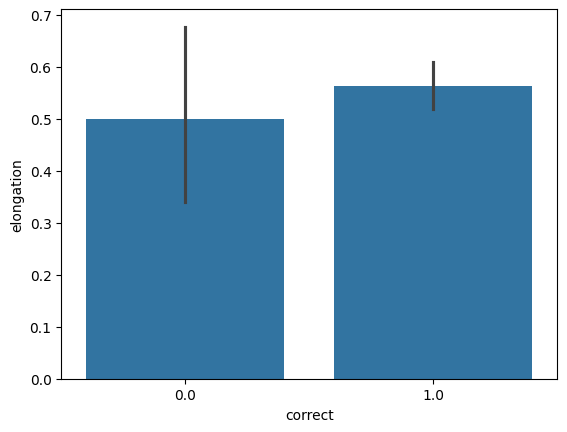

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


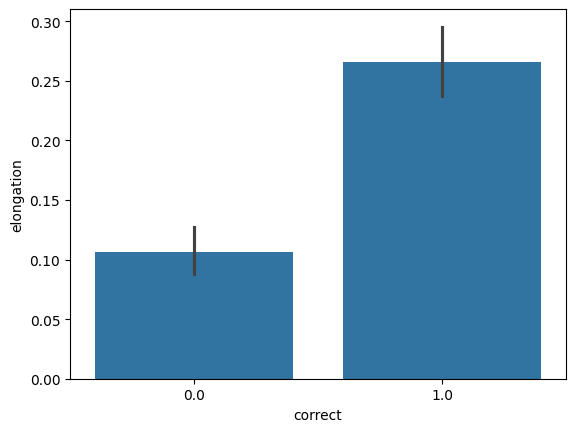

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


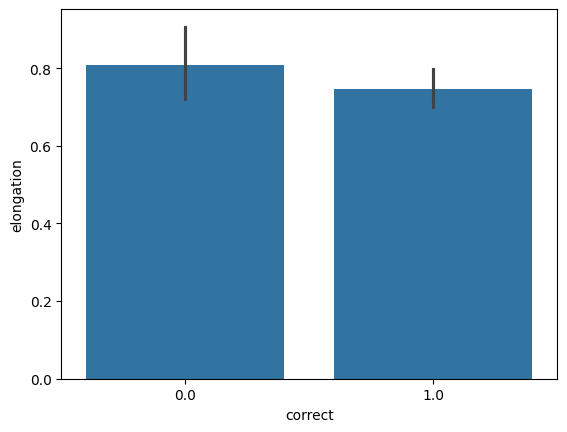

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


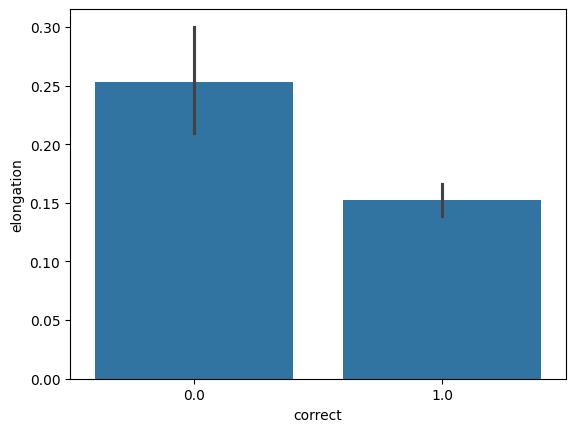

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


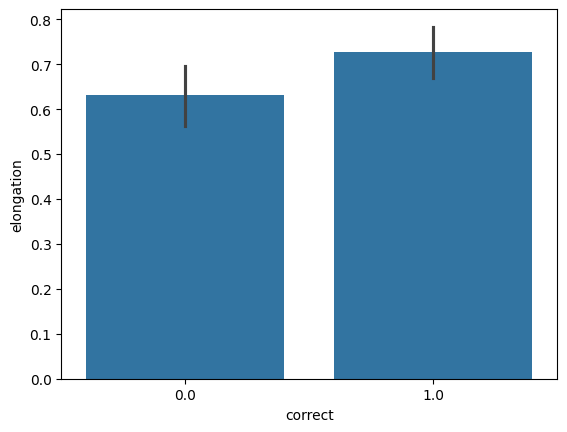

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


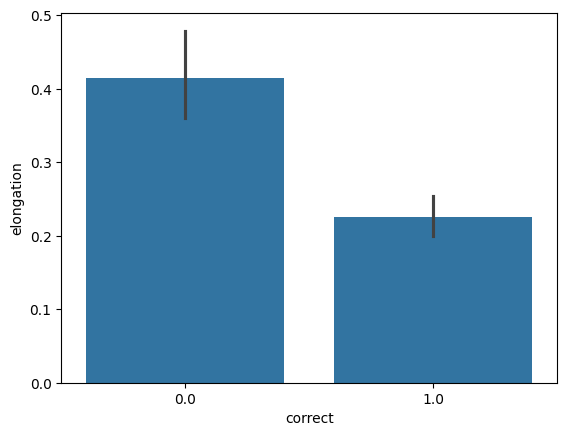

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


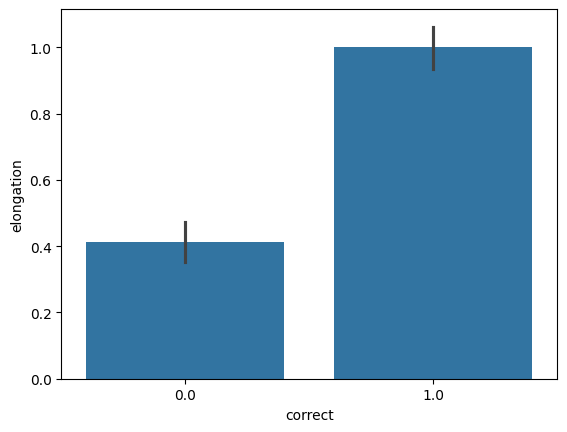

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


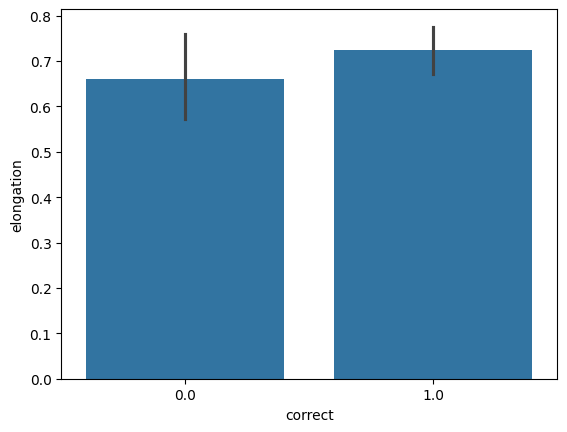

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


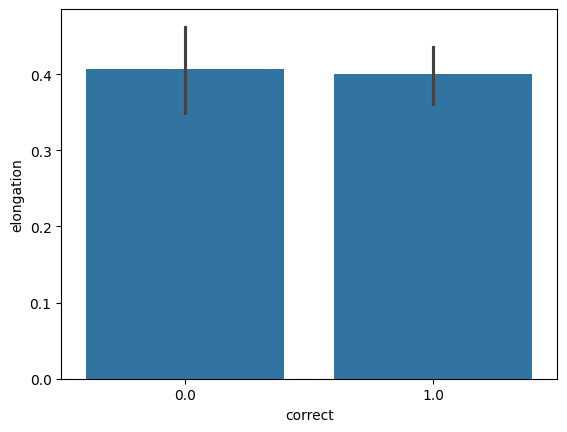

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


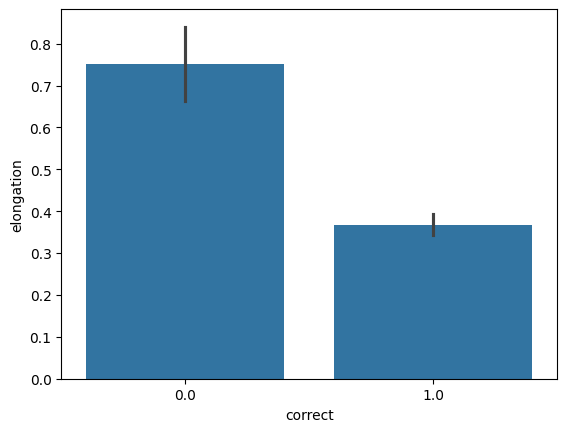

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


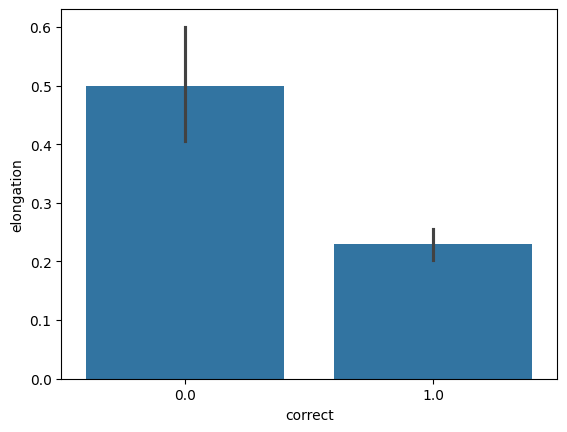

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


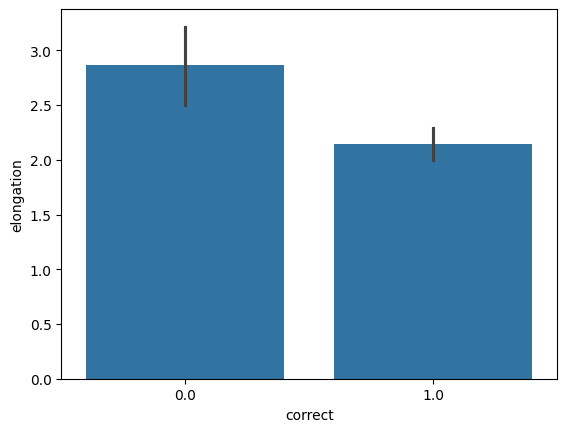

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


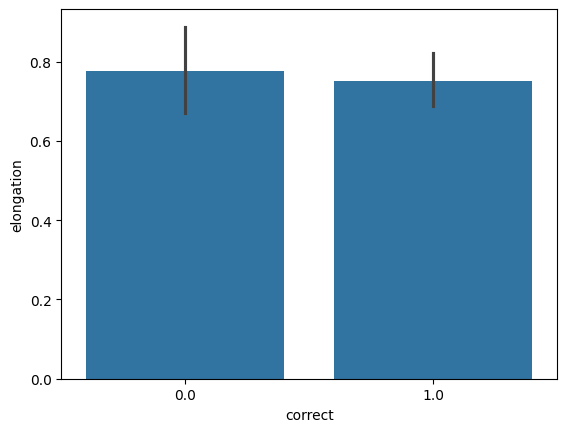

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


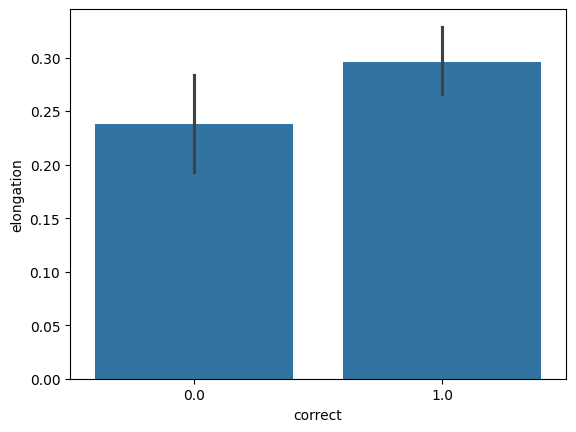

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


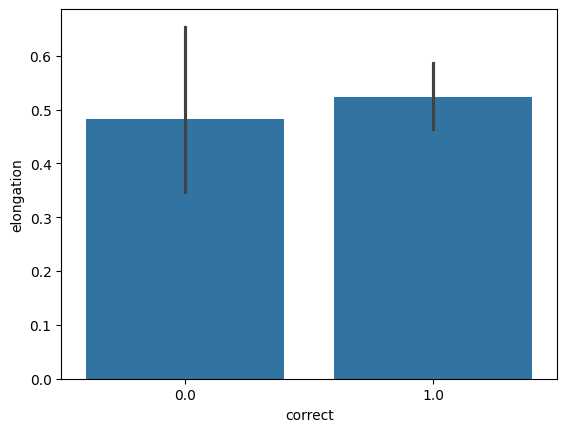

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


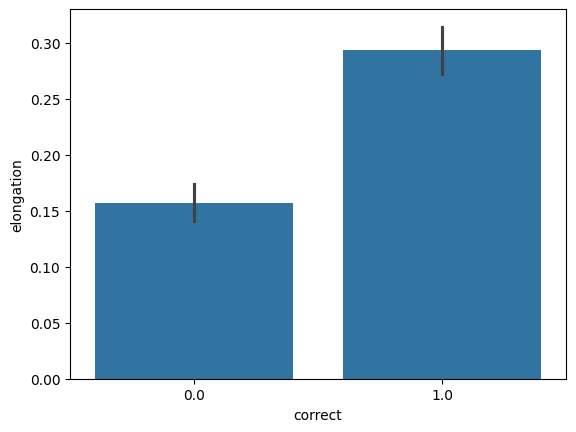

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


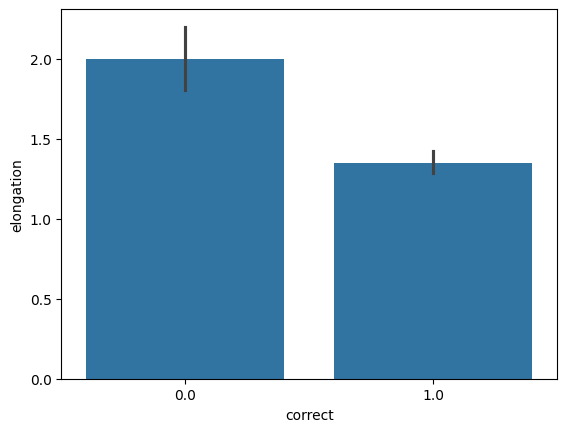

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


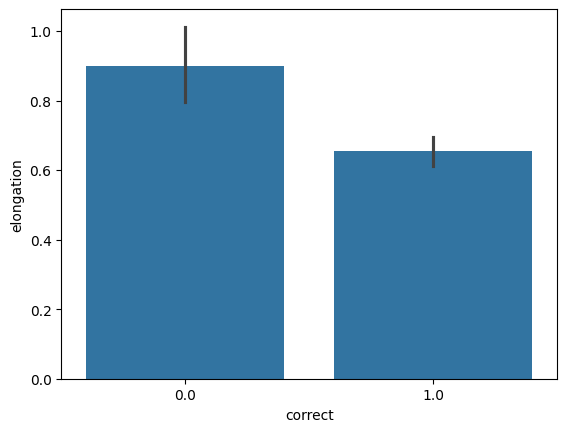

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


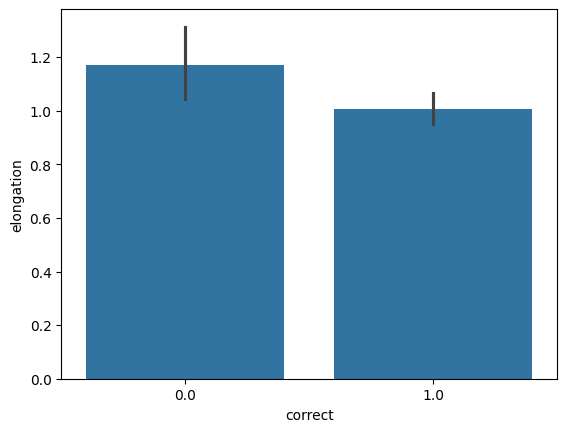

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


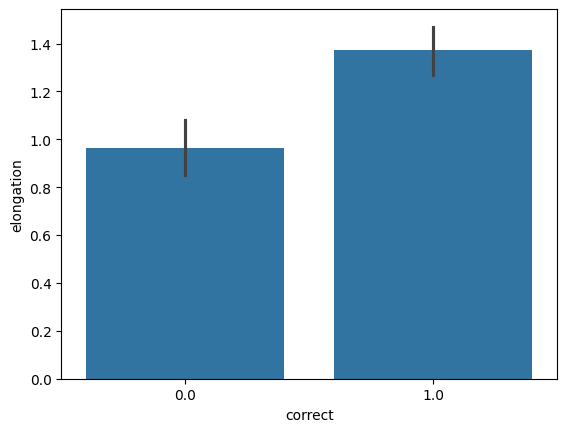

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


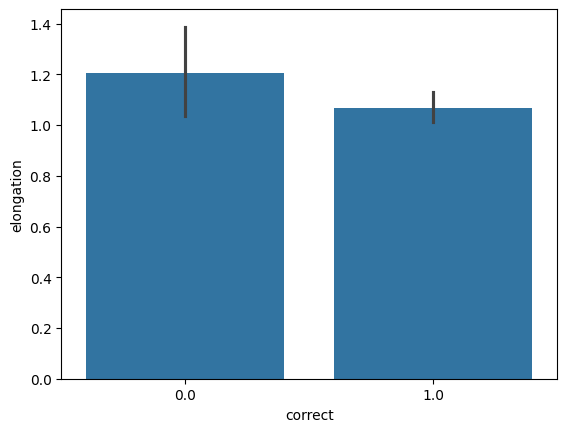

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


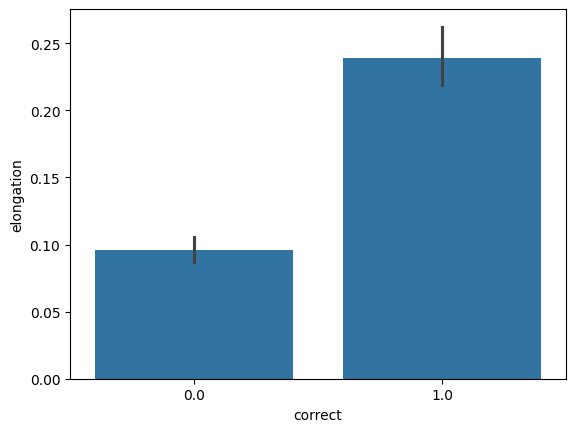

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


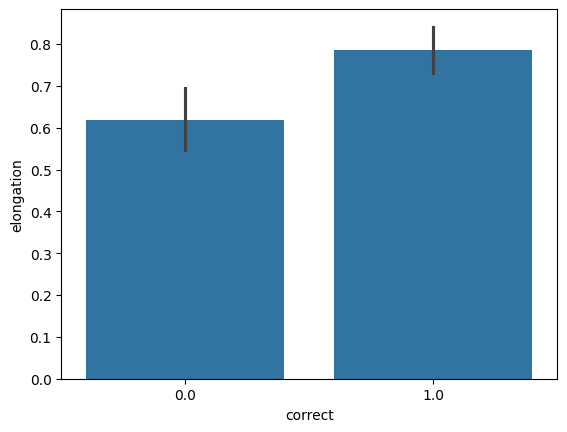

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


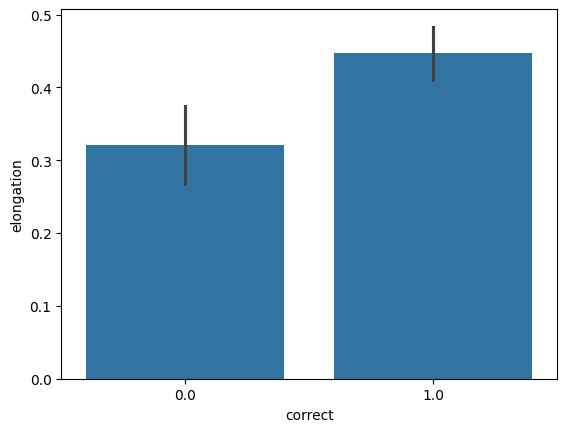

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


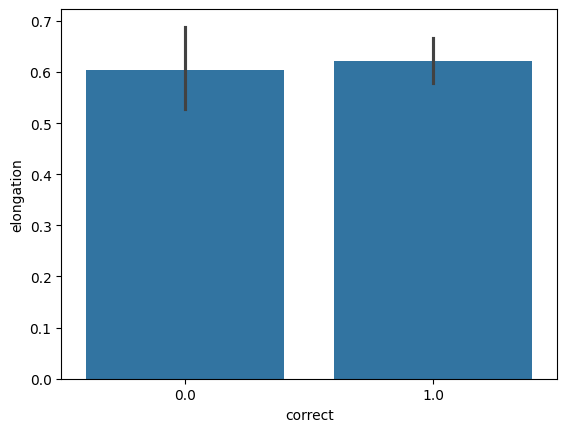

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


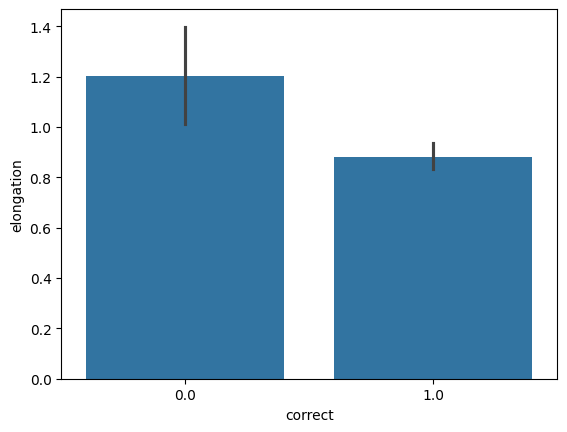

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


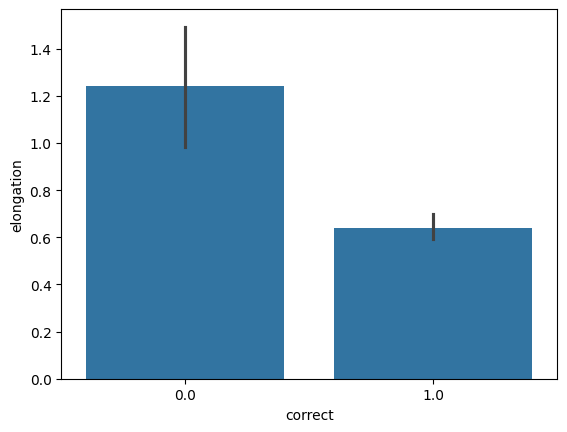

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


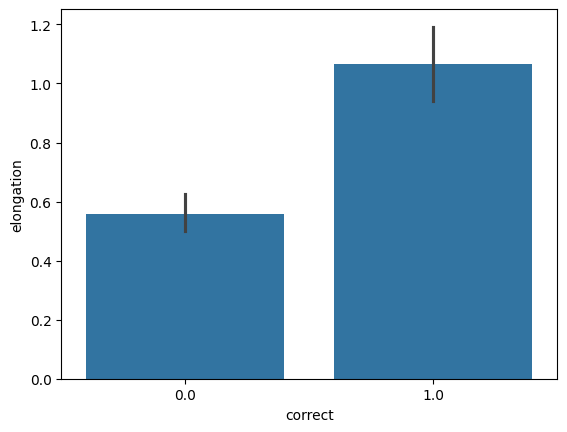

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


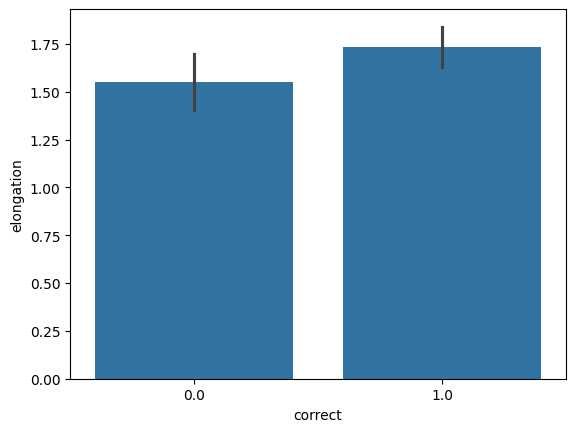

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


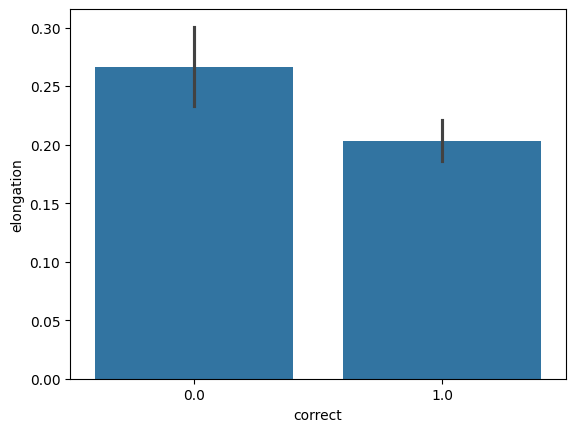

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


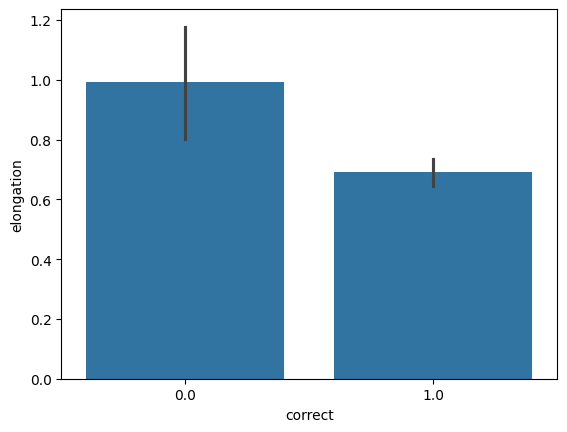

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


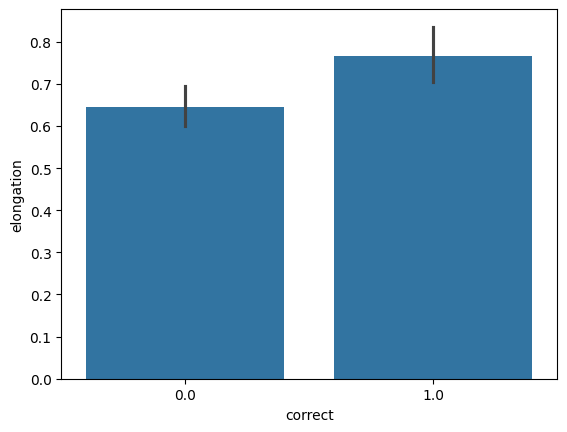

/tmp/ipykernel_23489/554007149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['past_feedback'] = use_data['wsls']


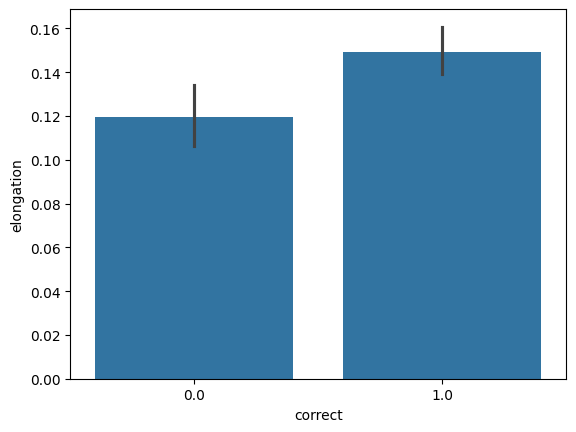

In [65]:
# Plot across sessions

for s, session in enumerate(states_trial_type['session'].unique()):
    use_data = states_trial_type.loc[states_trial_type['session']==session]
    use_data['past_feedback'] = use_data['wsls']
    use_data.loc[use_data['wsls']=='lsh', 'past_feedback'] = 'l'
    use_data.loc[use_data['wsls']=='ls', 'past_feedback'] = 'l'
    use_data.loc[use_data['wsls']=='wsh', 'past_feedback'] = 'w'
    use_data.loc[use_data['wsls']=='wst', 'past_feedback'] = 'w'
    sns.barplot(y='elongation', x='correct', data=use_data)
    # plt.ylim([0, 5])
    plt.show()

/tmp/ipykernel_23489/2459701915.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  reduced = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'correct', 'contrast'])['reaction', 'response', 'elongation'].mean())


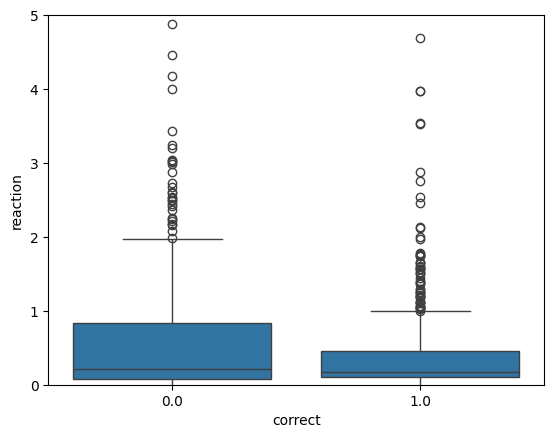

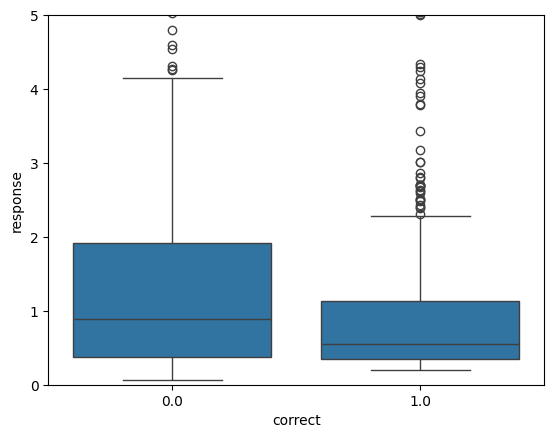

(0.0, 5.0)

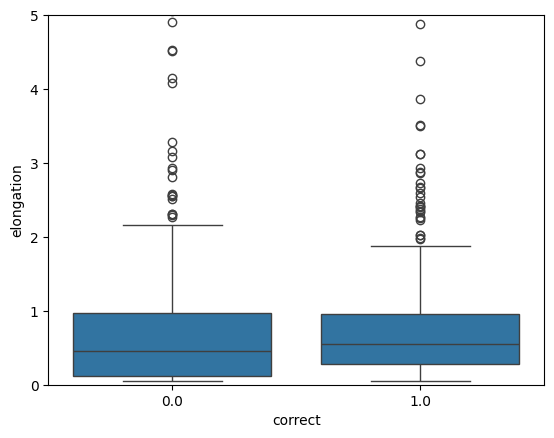

In [9]:
# Plot across sessions
reduced = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'correct', 'contrast'])['reaction', 'response', 'elongation'].mean())
reduced = reduced.reset_index(level=[0, 1, 2, 3])

sns.boxplot(y='reaction', x='correct', data=reduced)
plt.ylim([0, 5])
plt.show()
sns.boxplot(y='response', x='correct', data=reduced)
plt.ylim([0, 5])
plt.show()
sns.boxplot( y='elongation', x='correct', data=reduced)
plt.ylim([0, 5])

/tmp/ipykernel_23489/986400432.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  reduced = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'correct', 'contrast'])['reaction', 'response', 'elongation'].mean())


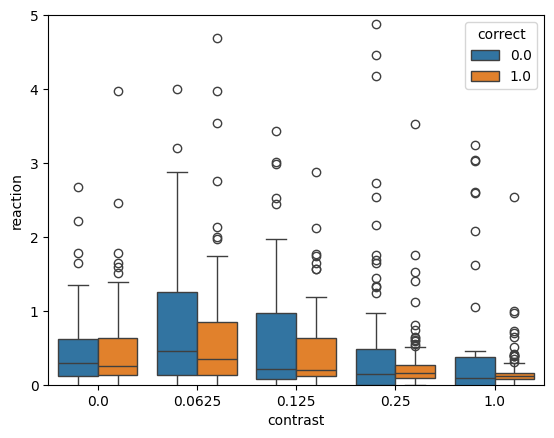

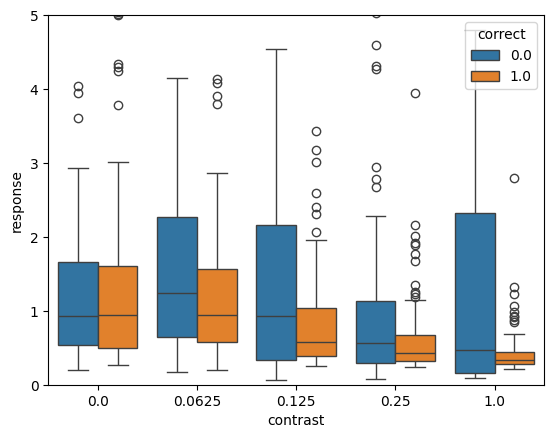

(0.0, 5.0)

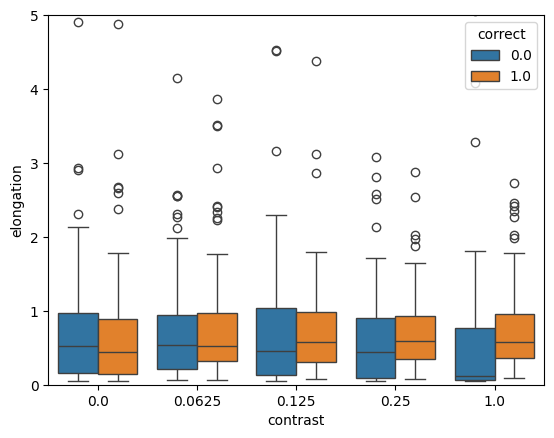

In [14]:
# Plot across sessions
reduced = pd.DataFrame(states_trial_type.groupby(['mouse_name', 'session', 'correct', 'contrast'])['reaction', 'response', 'elongation'].mean())
reduced = reduced.reset_index(level=[0, 1, 2, 3])

sns.boxplot(x='contrast', y='reaction', hue='correct', data=reduced)
plt.ylim([0, 5])
plt.show()
sns.boxplot(x='contrast', y='response', hue='correct', data=reduced)
plt.ylim([0, 5])
plt.show()
sns.boxplot(x='contrast', y='elongation', hue='correct', data=reduced)
plt.ylim([0, 5])